In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("Amazon_final_Dataset.csv")

In [4]:
df.shape

(1083620, 34)

In [5]:
df.columns

Index(['transaction_id', 'order_date', 'customer_id', 'product_id',
       'product_name', 'category', 'subcategory', 'brand',
       'original_price_inr', 'discount_percent', 'discounted_price_inr',
       'quantity', 'subtotal_inr', 'delivery_charges', 'final_amount_inr',
       'customer_city', 'customer_state', 'customer_tier',
       'customer_spending_tier', 'customer_age_group', 'payment_method',
       'delivery_days', 'delivery_type', 'is_prime_member', 'is_festival_sale',
       'festival_name', 'customer_rating', 'return_status', 'order_month',
       'order_year', 'order_quarter', 'product_weight_kg', 'is_prime_eligible',
       'product_rating'],
      dtype='object')

In [6]:
df.isna()

transaction_id  order_date  customer_id  product_id  product_name  \
0                 False       False        False       False         False   
1                 False       False        False       False         False   
2                 False       False        False       False         False   
3                 False       False        False       False         False   
4                 False       False        False       False         False   
...                 ...         ...          ...         ...           ...   
1083615           False       False        False       False         False   
1083616           False       False        False       False         False   
1083617           False       False        False       False         False   
1083618           False       False        False       False         False   
1083619           False       False        False       False         False   

         category  subcategory  brand  original_price_inr  discount_percent  \
0           False        False  False               False             False   
1           False        False  False               False             False   
2           False        False  False               False             False   
3           False        False  False               False             False   
4           False        False  False               False             False   
...           ...          ...    ...                 ...               ...   
1083615     False        False  False               False             False   
1083616     False        False  False               False             False   
1083617     False        False  False               False             False   
1083618     False        False  False               False             False   
1083619     False        False  False               False             False   

         ...  is_festival_sale  festival_name  customer_rating  return_status  \
0        ...             False          False            False          False   
1        ...             False          False            False          False   
2        ...             False          False            False          False   
3        ...             False          False            False          False   
4        ...             False          False            False          False   
...      ...               ...            ...              ...            ...   
1083615  ...             False          False            False          False   
1083616  ...             False          False            False          False   
1083617  ...             False          False            False          False   
1083618  ...             False          False            False          False   
1083619  ...             False          False            False          False   

         order_month  order_year  order_quarter  product_weight_kg  \
0              False       False          False              False   
1              False       False          False              False   
2              False       False          False              False   
3              False       False          False              False   
4              False       False          False              False   
...              ...         ...            ...                ...   
1083615        False       False          False              False   
1083616        False       False          False              False   
1083617        False       False          False              False   
1083618        False       False          False              False   
1083619        False       False          False              False   

         is_prime_eligible  product_rating  
0                    False           False  
1                    False           False  
2                    False           False  
3                    False           False  
4                    False           False  
...                    ...             

EXPLORTORY DATA ANALYSIS


1. Creation of a comprehensive revenue trend analysis showing yearly revenue growth from 2015-2025. 

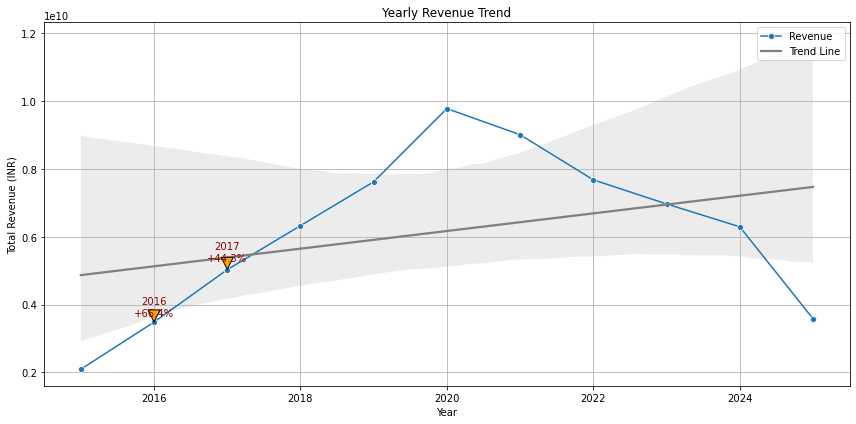

In [34]:
yearly_revenue = df.groupby('order_year')['final_amount_inr'].sum().reset_index()

# Calculate percentage growth rates
yearly_revenue['yearly_growth_rate'] = yearly_revenue['final_amount_inr'].pct_change() * 100

# Identify key growth periods (top 2 highest growth rates)
key_growth_years = yearly_revenue.nlargest(2, 'yearly_growth_rate')['order_year'].tolist()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_revenue, x='order_year', y='final_amount_inr', marker='o', label='Revenue')
sns.regplot(data=yearly_revenue, x='order_year', y='final_amount_inr', scatter=False, color='gray', label='Trend Line')

# Annotate key growth periods
for year in key_growth_years:
    value = yearly_revenue.loc[yearly_revenue['order_year'] == year, 'final_amount_inr'].values[0]
    growth = yearly_revenue.loc[yearly_revenue['order_year'] == year, 'yearly_growth_rate'].values[0]
    plt.annotate(f"{year}\n+{growth:.1f}%", 
                 xy=(year, value), 
                 xytext=(year, value*1.05),
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10, color='darkred', ha='center')

plt.title('Yearly Revenue Trend')
plt.xlabel('Year')
plt.ylabel('Total Revenue (INR)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2 . Analyze seasonal patterns in sales data. Create monthly sales heatmaps and identify peak selling months. Compare seasonal trends across different years and categories.


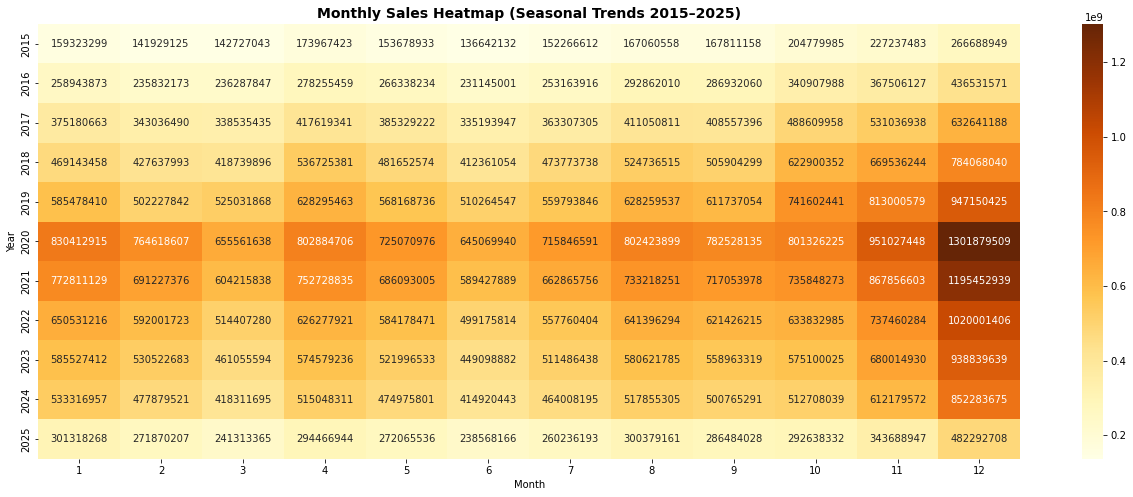

In [11]:


monthly_sales = df.groupby(['order_year','order_month'])['final_amount_inr'].sum().unstack(fill_value=0)
plt.figure(figsize=(22,8))
sns.heatmap(monthly_sales, cmap="YlOrBr", annot=True, fmt=".0f")
plt.title("Monthly Sales Heatmap (Seasonal Trends 2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()




Top Selling Months:
order_month
12    8.857830e+09
11    6.800545e+09
10    5.950255e+09
4     5.600849e+09
8     5.599864e+09
Name: final_amount_inr, dtype: float64


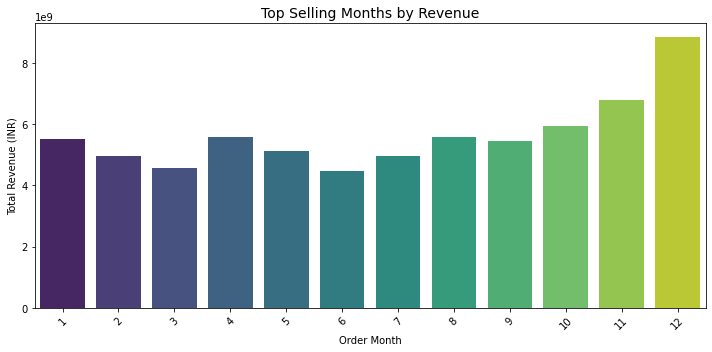

In [36]:

# Identify peak months
monthly_totals = df.groupby('order_month')['final_amount_inr'].sum().sort_values(ascending=False)
print("Top Selling Months:")
print(monthly_totals.head())
monthly_df = monthly_totals.reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='order_month', y='final_amount_inr', data=monthly_df, palette='viridis')

plt.title('Top Selling Months by Revenue', fontsize=14)
plt.xlabel('Order Month')
plt.ylabel('Total Revenue (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3 . Build a customer segmentation analysis using RFM (Recency, Frequency, Monetary) methodology. Create scatter plots and segment customers into meaningful groups with actionable insights.


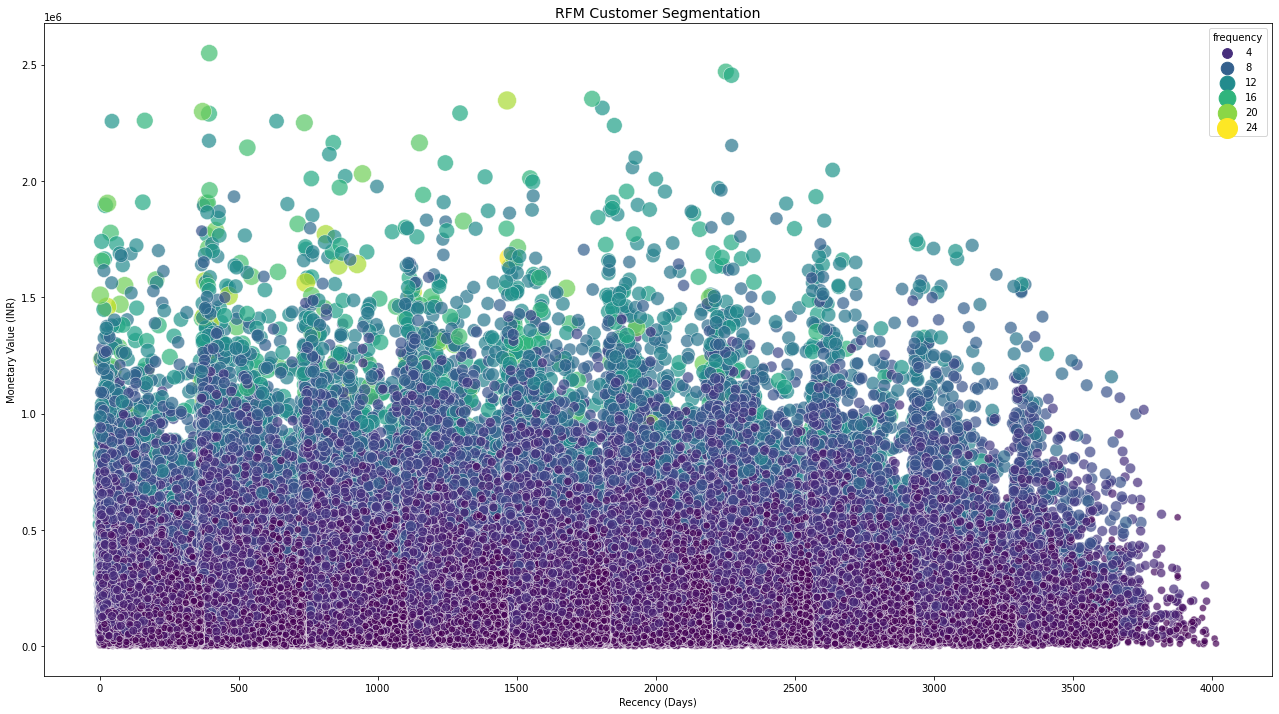

In [18]:
df['order_date'] = pd.to_datetime(df['order_date'])


snapshot_date = df['order_date'].max()

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'transaction_id': 'count',                               # Frequency
    'final_amount_inr': 'sum'                                # Monetary
}).reset_index()


rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']


plt.figure(figsize=(22,12))
sns.scatterplot(data=rfm, x='recency', y='monetary', size='frequency',hue='frequency',       
    palette='viridis',      # Try others: 'coolwarm', 'plasma', 'Spectral', 'magma'
    alpha=0.7,
    sizes=(50, 400))
plt.title("RFM Customer Segmentation", fontsize=14)
plt.xlabel("Recency (Days)")
plt.ylabel("Monetary Value (INR)")
plt.show()

4 . Visualize the evolution of payment methods from 2015-2025. Show the rise of UPI, decline of COD, and create stacked area charts to demonstrate market share changes over time.

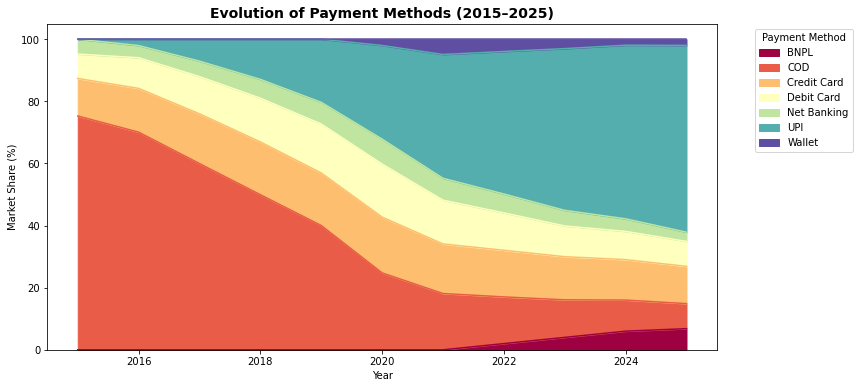

In [38]:

payment_trend = df.groupby(['order_year','payment_method']).size().unstack(fill_value=0)
payment_trend_pct = payment_trend.div(payment_trend.sum(axis=1), axis=0) * 100

payment_trend_pct.plot(kind='area', stacked=True, figsize=(12,6), colormap='Spectral')
plt.title("Evolution of Payment Methods (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.legend(title="Payment Method", bbox_to_anchor=(1.05,1))
plt.show()


5 . Perform category-wise performance analysis. Create  bar charts, and pie charts showing revenue contribution, growth rates, and market share for each product category.


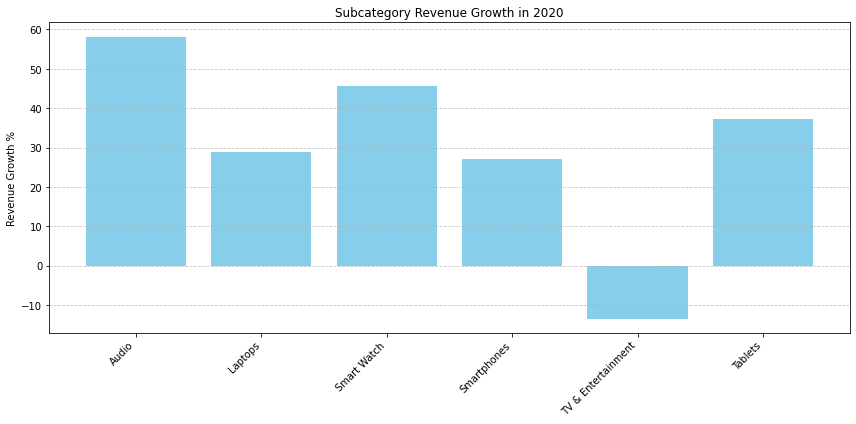

In [29]:
subcat_revenue = df.groupby(['category','subcategory'])['final_amount_inr'].sum().reset_index()

# Sort by revenue descending
subcat_revenue = subcat_revenue.sort_values('final_amount_inr', ascending=False)

yearly_subcat = df.groupby(['order_year','subcategory'])['final_amount_inr'].sum().reset_index()
yearly_subcat = yearly_subcat.sort_values(['subcategory','order_year'])

yearly_subcat['Revenue_Growth_%'] = yearly_subcat.groupby('subcategory')['final_amount_inr'].pct_change() * 100

latest_year = 2020
growth_latest = yearly_subcat[yearly_subcat['order_year']==latest_year]

plt.figure(figsize=(12,6))
plt.bar(growth_latest['subcategory'], growth_latest['Revenue_Growth_%'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Revenue Growth %')
plt.title(f'Subcategory Revenue Growth in {latest_year}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


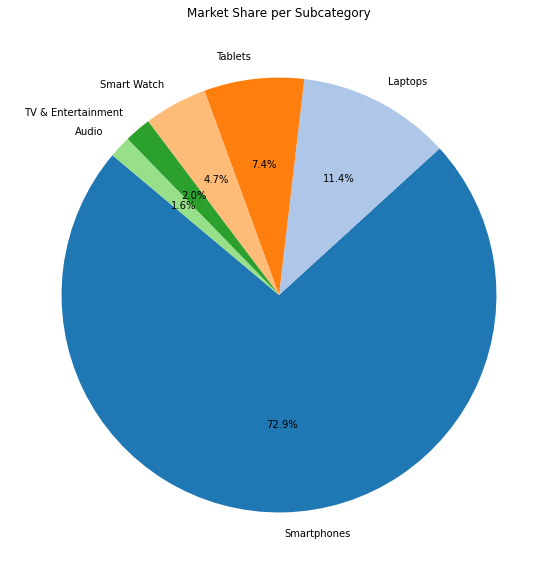

In [30]:
total_revenue = subcat_revenue['final_amount_inr'].sum()
subcat_revenue['Market_Share_%'] = subcat_revenue['final_amount_inr'] / total_revenue * 100

plt.figure(figsize=(10,10))
plt.pie(subcat_revenue['Market_Share_%'], 
        labels=subcat_revenue['subcategory'], 
        autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Market Share per Subcategory')
plt.show()


6 .Analyze Prime membership impact on customer behavior. Compare average order values, order frequency, and category preferences between Prime and non-Prime customers using multiple visualization types.


Average Order Value by Prime Membership:
   is_prime_member  average_order_value
0            False         58793.187373
1             True         69108.032903


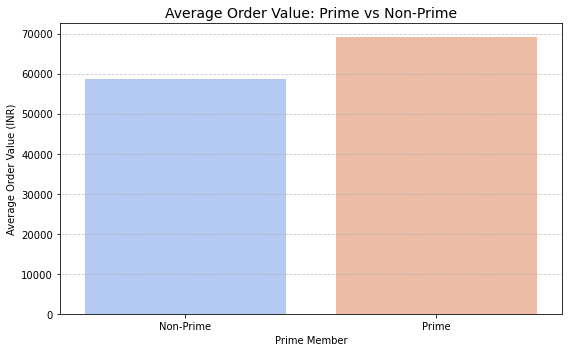


Order Frequency by Prime Membership:
   is_prime_member  order_frequency
0            False           680229
1             True           403391


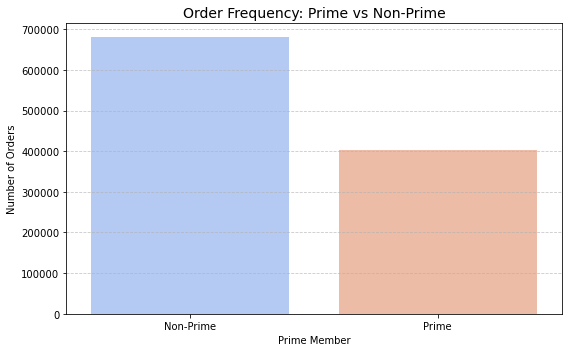


Category Preferences for Prime Members:
    is_prime_member         subcategory  total_revenue
9              True         Smartphones   2.029272e+10
7              True             Laptops   3.291602e+09
11             True             Tablets   2.105063e+09
8              True         Smart Watch   1.206974e+09
10             True  TV & Entertainment   6.182123e+08
6              True               Audio   3.629832e+08

Category Preferences for Non-Prime Members:
   is_prime_member         subcategory  total_revenue
3            False         Smartphones   2.917272e+10
1            False             Laptops   4.426229e+09
5            False             Tablets   2.939852e+09
2            False         Smart Watch   1.984094e+09
0            False               Audio   7.403804e+08
4            False  TV & Entertainment   7.295538e+08


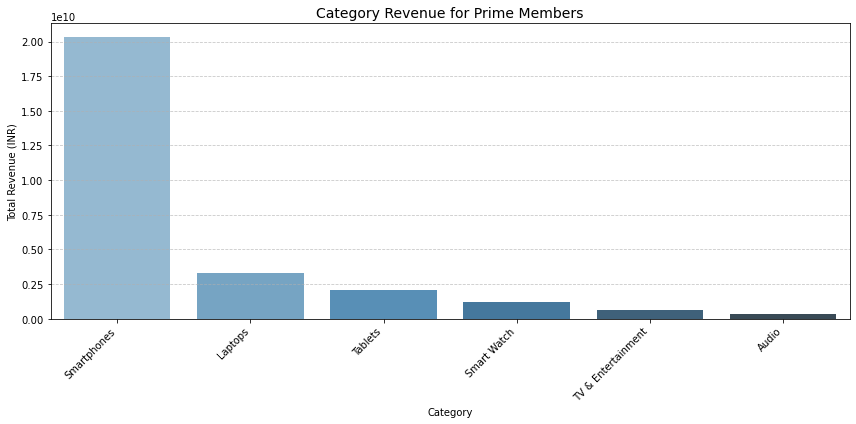

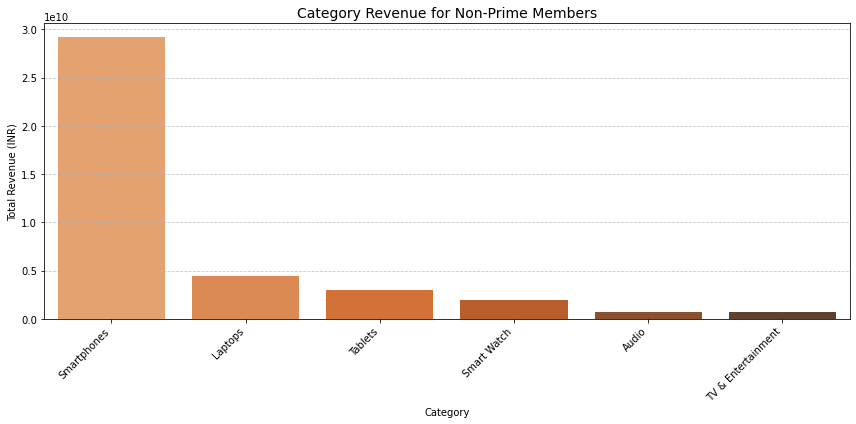

In [39]:
# Average Order Value (AOV) by Prime Membership
aov_df = df.groupby('is_prime_member')['final_amount_inr'].mean().reset_index(name='average_order_value')
print("Average Order Value by Prime Membership:")
print(aov_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='is_prime_member', y='average_order_value', data=aov_df, palette='coolwarm')
plt.title('Average Order Value: Prime vs Non-Prime', fontsize=14)
plt.xlabel('Prime Member')
plt.ylabel('Average Order Value (INR)')
plt.xticks([0, 1], ['Non-Prime', 'Prime'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Order Frequency by Prime Membership
order_frequency_df = df.groupby('is_prime_member').size().reset_index(name='order_frequency')
print("\nOrder Frequency by Prime Membership:")
print(order_frequency_df)

plt.figure(figsize=(8, 5))
sns.barplot(x='is_prime_member', y='order_frequency', data=order_frequency_df, palette='coolwarm')
plt.title('Order Frequency: Prime vs Non-Prime', fontsize=14)
plt.xlabel('Prime Member')
plt.ylabel('Number of Orders')
plt.xticks([0, 1], ['Non-Prime', 'Prime'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Category Preferences: Prime vs Non-Prime
category_preferences = df.groupby(['is_prime_member', 'subcategory'])['final_amount_inr'].sum().reset_index(name='total_revenue')

prime_preferences = category_preferences[category_preferences['is_prime_member'] == True]
non_prime_preferences = category_preferences[category_preferences['is_prime_member'] == False]

print("\nCategory Preferences for Prime Members:")
print(prime_preferences.sort_values('total_revenue', ascending=False))

print("\nCategory Preferences for Non-Prime Members:")
print(non_prime_preferences.sort_values('total_revenue', ascending=False))


# Visualization: Prime Members
plt.figure(figsize=(12, 6))
sns.barplot(
    x='subcategory', 
    y='total_revenue', 
    data=prime_preferences.sort_values('total_revenue', ascending=False),
    palette='Blues_d'
)
plt.title('Category Revenue for Prime Members', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Total Revenue (INR)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualization: Non-Prime Members
plt.figure(figsize=(12, 6))
sns.barplot(
    x='subcategory', 
    y='total_revenue', 
    data=non_prime_preferences.sort_values('total_revenue', ascending=False),
    palette='Oranges_d'
)
plt.title('Category Revenue for Non-Prime Members', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Total Revenue (INR)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


7. Create geographic analysis of sales performance across Indian cities and states. Build choropleth maps and bar charts showing revenue density and growth patterns by tier (Metro/Tier1/Tier2/Rural).

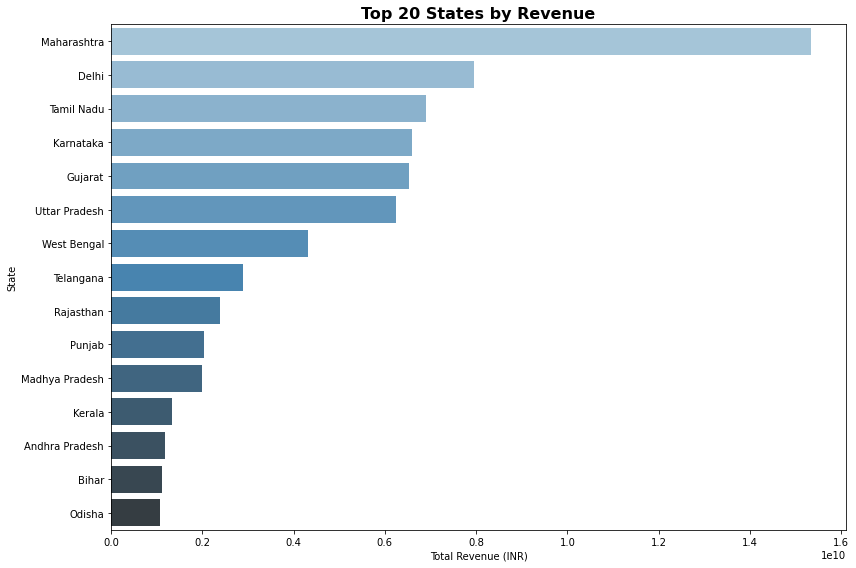

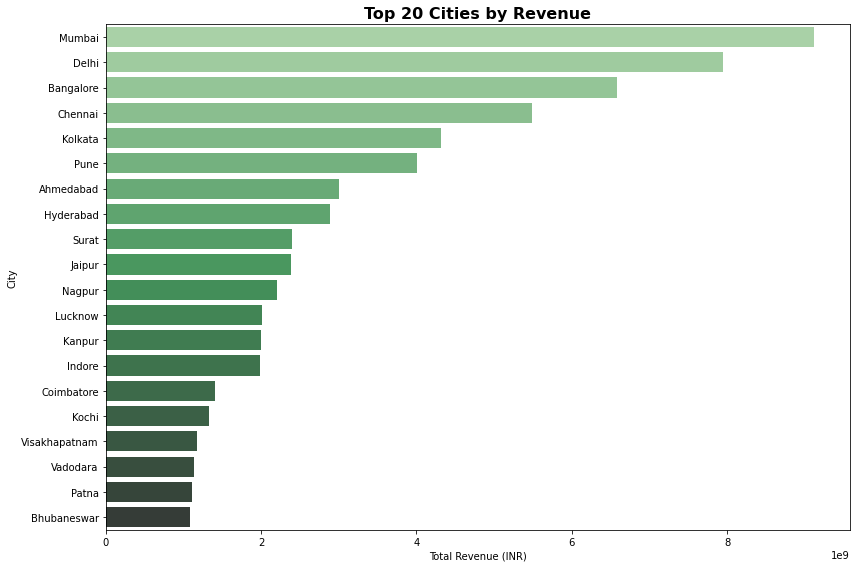

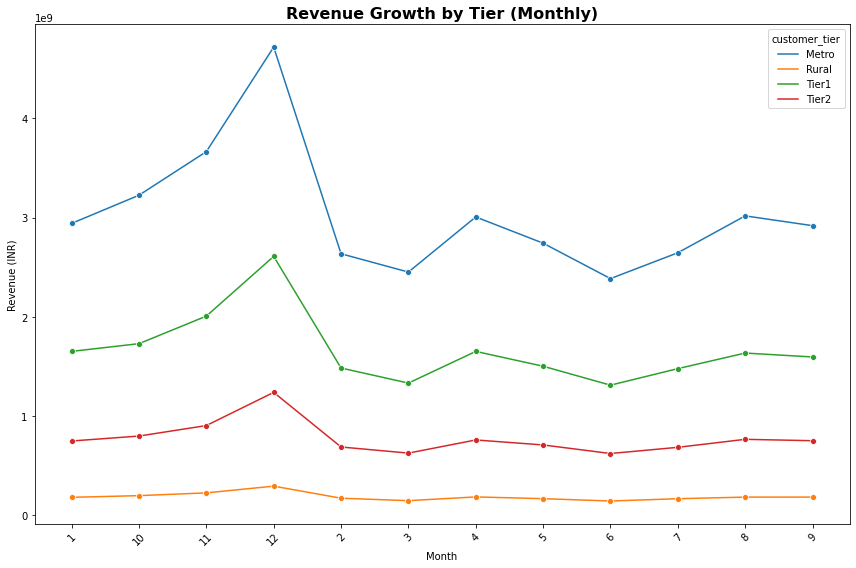

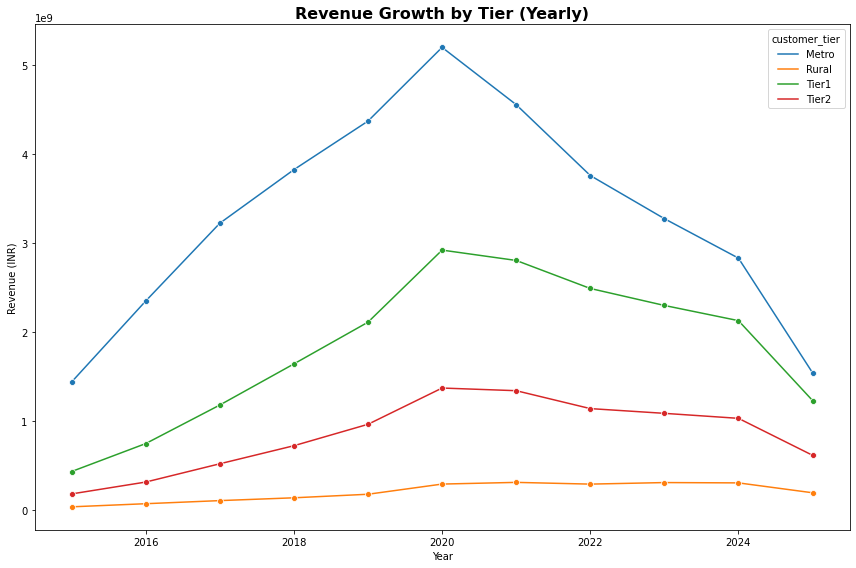

In [40]:
# Add revenue column
df['revenue'] = df['final_amount_inr']


# Revenue by State
state_revenue = df.groupby('customer_state')['revenue'].sum().reset_index()
top_states = state_revenue.sort_values('revenue', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='revenue', y='customer_state', data=top_states, palette='Blues_d')
plt.title('Top 20 States by Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Total Revenue (INR)')
plt.ylabel('State')
plt.tight_layout()
plt.show()


# Revenue by City
city_revenue = df.groupby('customer_city')['revenue'].sum().reset_index()
top_cities = city_revenue.sort_values('revenue', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='revenue', y='customer_city', data=top_cities, palette='Greens_d')
plt.title('Top 20 Cities by Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Total Revenue (INR)')
plt.ylabel('City')
plt.tight_layout()
plt.show()


# Revenue Growth by Tier (Monthly)
df['order_month_str'] = df['order_month'].astype(str)
tier_monthly_revenue = df.groupby(['customer_tier', 'order_month_str'])['revenue'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x='order_month_str', y='revenue', hue='customer_tier', data=tier_monthly_revenue, marker='o')
plt.title('Revenue Growth by Tier (Monthly)', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Revenue Growth by Tier (Yearly)
tier_yearly_revenue = df.groupby(['customer_tier', 'order_year'])['revenue'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x='order_year', y='revenue', hue='customer_tier', data=tier_yearly_revenue, marker='o')
plt.title('Revenue Growth by Tier (Yearly)', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Revenue (INR)')
plt.tight_layout()
plt.show()


 8 . Study festival sales impact using before/during/after analysis. Visualize revenue spikes during Diwali, Prime Day, and other festivals with detailed time series analysis.


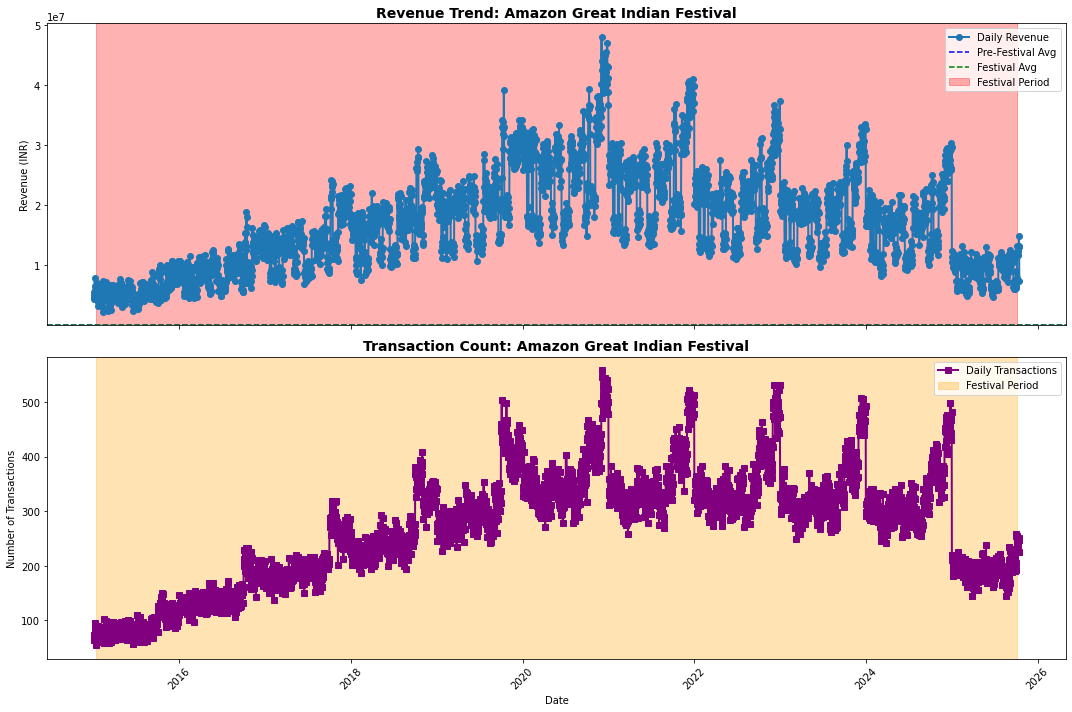


Amazon Great Indian Festival Sales Impact Analysis:
Festival Duration: 3922 days

Revenue Summary:
Before Festival: ₹49,588,834 (4,958,883/day)
During Festival: ₹66,745,208,457 (17,018,156/day)
After Festival: ₹122,561,683 (12,256,168/day)

Impact:
Revenue Boost vs Pre-Festival: +243.2%
Post-Festival Effect vs Pre-Festival: +147.2%




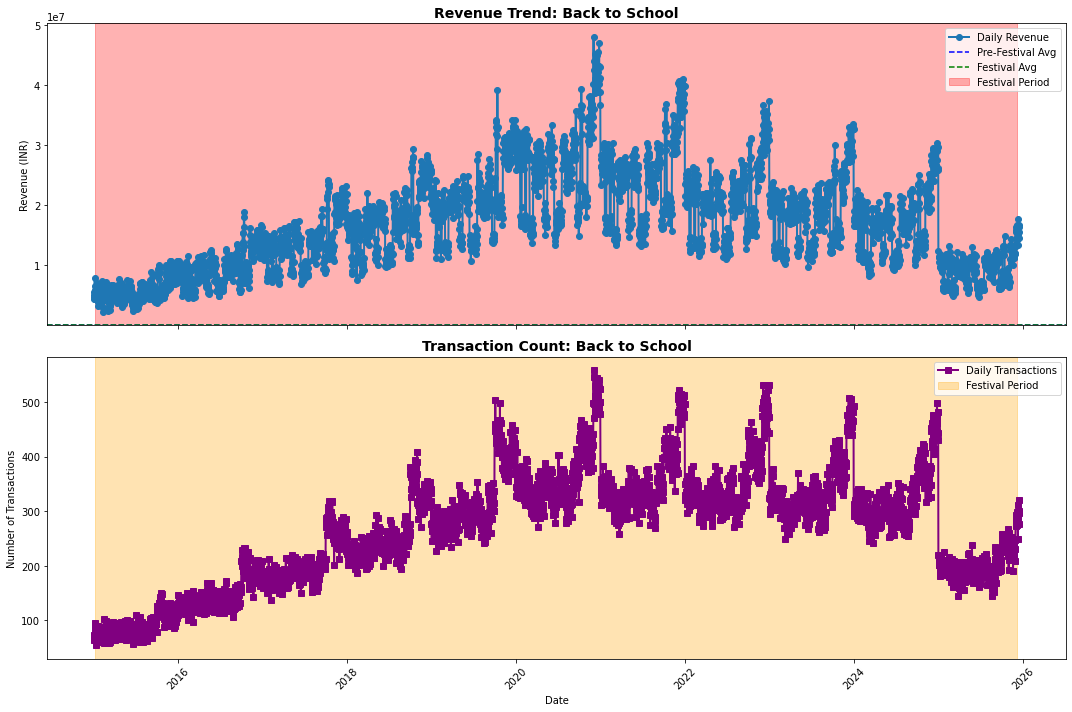


Back to School Sales Impact Analysis:
Festival Duration: 3988 days

Revenue Summary:
Before Festival: ₹34,174,697 (3,417,470/day)
During Festival: ₹67,463,312,935 (16,916,578/day)
After Festival: ₹155,985,996 (15,598,600/day)

Impact:
Revenue Boost vs Pre-Festival: +395.0%
Post-Festival Effect vs Pre-Festival: +356.4%




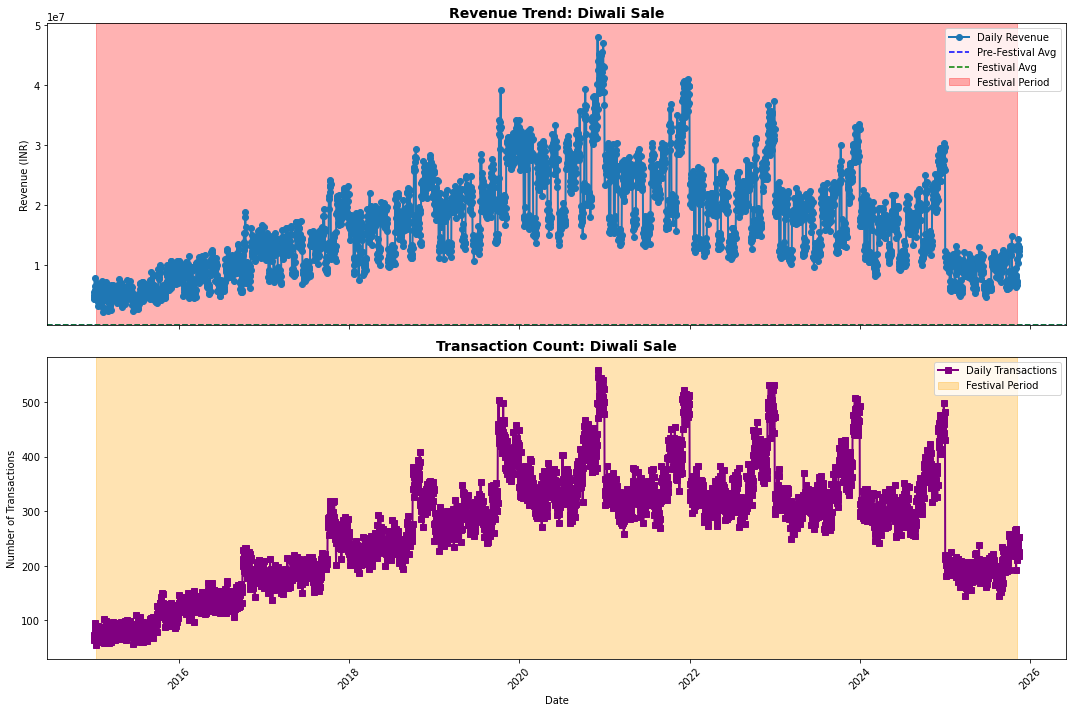


Diwali Sale Sales Impact Analysis:
Festival Duration: 3952 days

Revenue Summary:
Before Festival: ₹54,790,978 (5,479,098/day)
During Festival: ₹67,027,154,231 (16,960,312/day)
After Festival: ₹125,274,512 (12,527,451/day)

Impact:
Revenue Boost vs Pre-Festival: +209.5%
Post-Festival Effect vs Pre-Festival: +128.6%




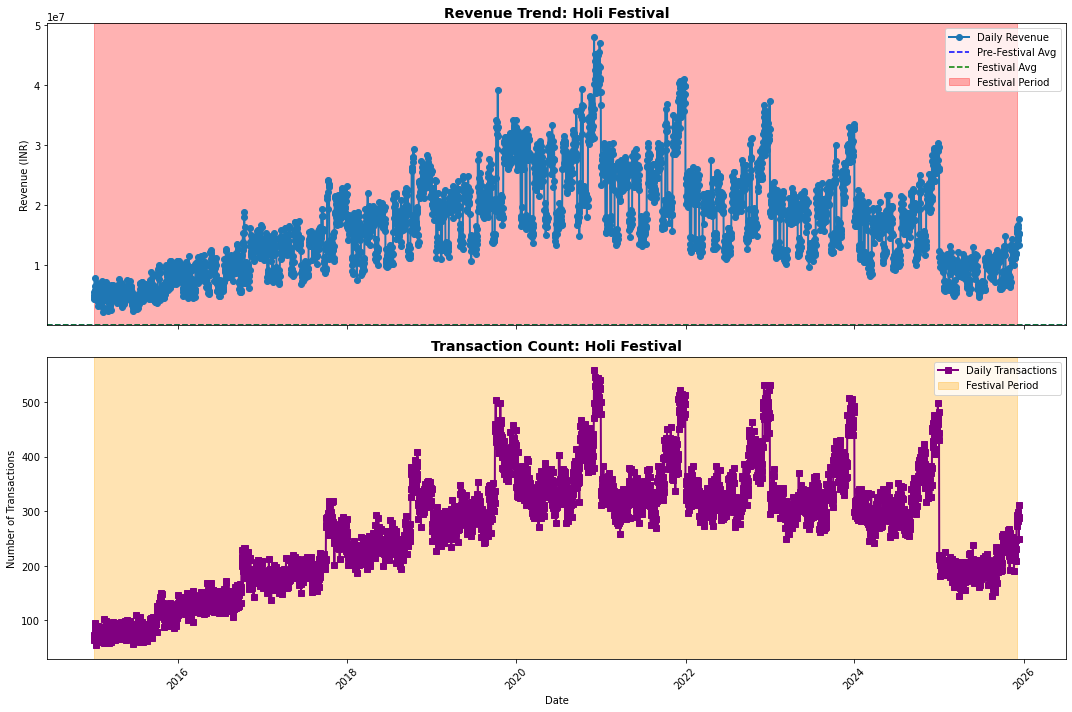


Holi Festival Sales Impact Analysis:
Festival Duration: 3988 days

Revenue Summary:
Before Festival: ₹9,232,329 (923,233/day)
During Festival: ₹67,425,947,202 (16,907,208/day)
After Festival: ₹154,969,529 (15,496,953/day)

Impact:
Revenue Boost vs Pre-Festival: +1731.3%
Post-Festival Effect vs Pre-Festival: +1578.6%




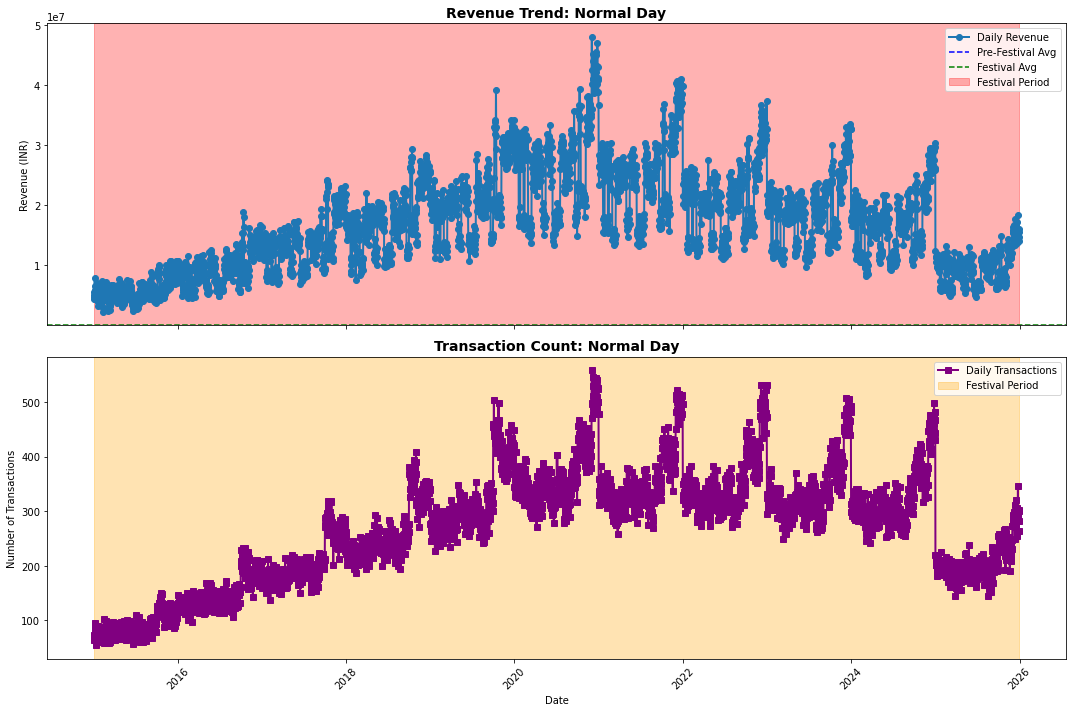


Normal Day Sales Impact Analysis:
Festival Duration: 4018 days

Revenue Summary:
Before Festival: ₹0 (0/day)
During Festival: ₹67,870,389,554 (16,891,585/day)
After Festival: ₹0 (0/day)

Impact:
Revenue Boost vs Pre-Festival: +inf%
Post-Festival Effect vs Pre-Festival: +nan%




C:\Users\SATHIS~1\AppData\Local\Temp/ipykernel_3680/1487832649.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  print(f"Revenue Boost vs Pre-Festival: {((during_total/festival_days)/(before_total/days_before)-1)*100:+.1f}%")
C:\Users\SATHIS~1\AppData\Local\Temp/ipykernel_3680/1487832649.py:77: RuntimeWarning: invalid value encountered in double_scalars
  print(f"Post-Festival Effect vs Pre-Festival: {((after_total/days_after)/(before_total/days_before)-1)*100:+.1f}%")


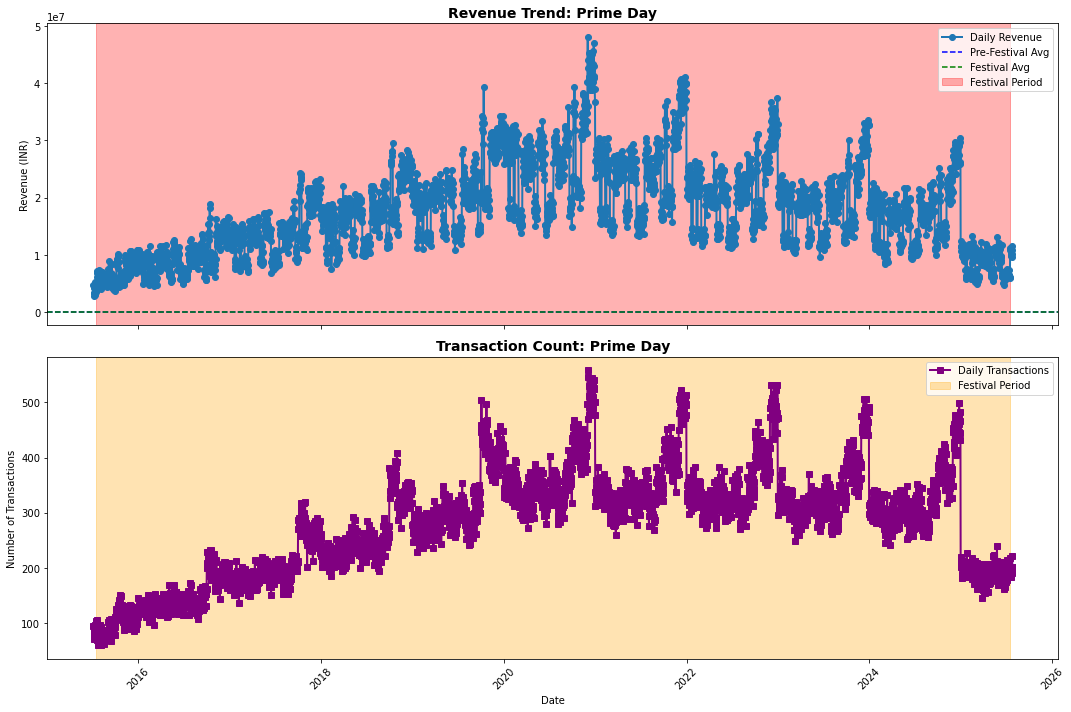


Prime Day Sales Impact Analysis:
Festival Duration: 3656 days

Revenue Summary:
Before Festival: ₹39,593,884 (3,959,388/day)
During Festival: ₹65,052,470,062 (17,793,345/day)
After Festival: ₹105,280,076 (10,528,008/day)

Impact:
Revenue Boost vs Pre-Festival: +349.4%
Post-Festival Effect vs Pre-Festival: +165.9%




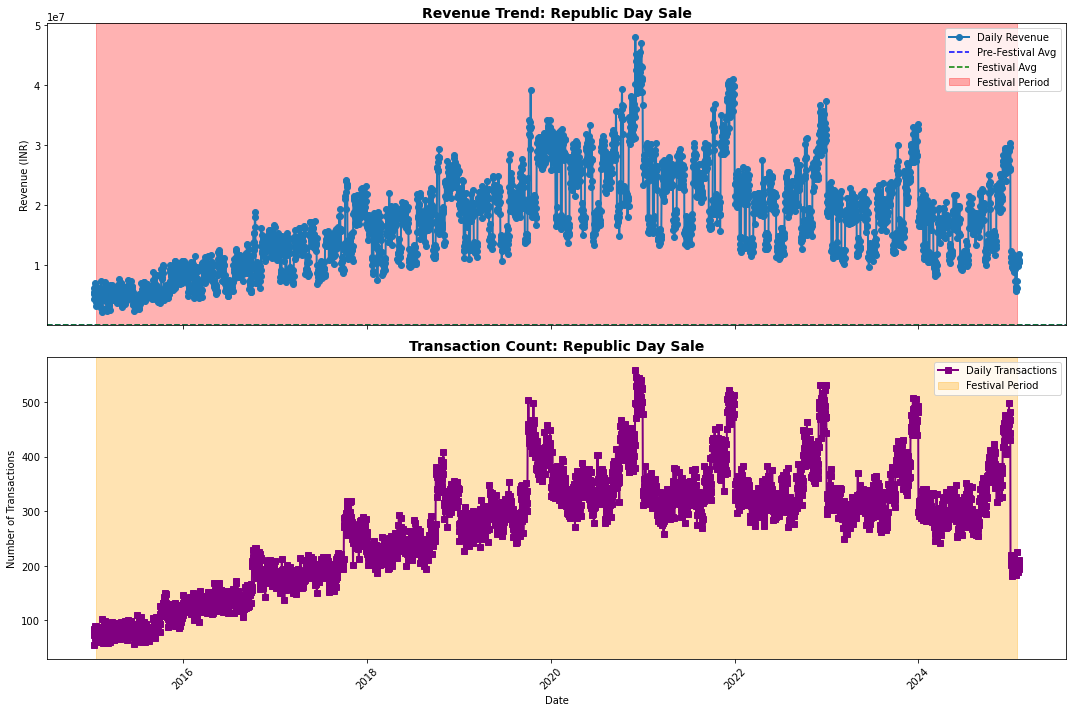


Republic Day Sale Sales Impact Analysis:
Festival Duration: 3660 days

Revenue Summary:
Before Festival: ₹57,609,002 (5,760,900/day)
During Festival: ₹64,426,058,043 (17,602,748/day)
After Festival: ₹107,368,193 (10,736,819/day)

Impact:
Revenue Boost vs Pre-Festival: +205.6%
Post-Festival Effect vs Pre-Festival: +86.4%




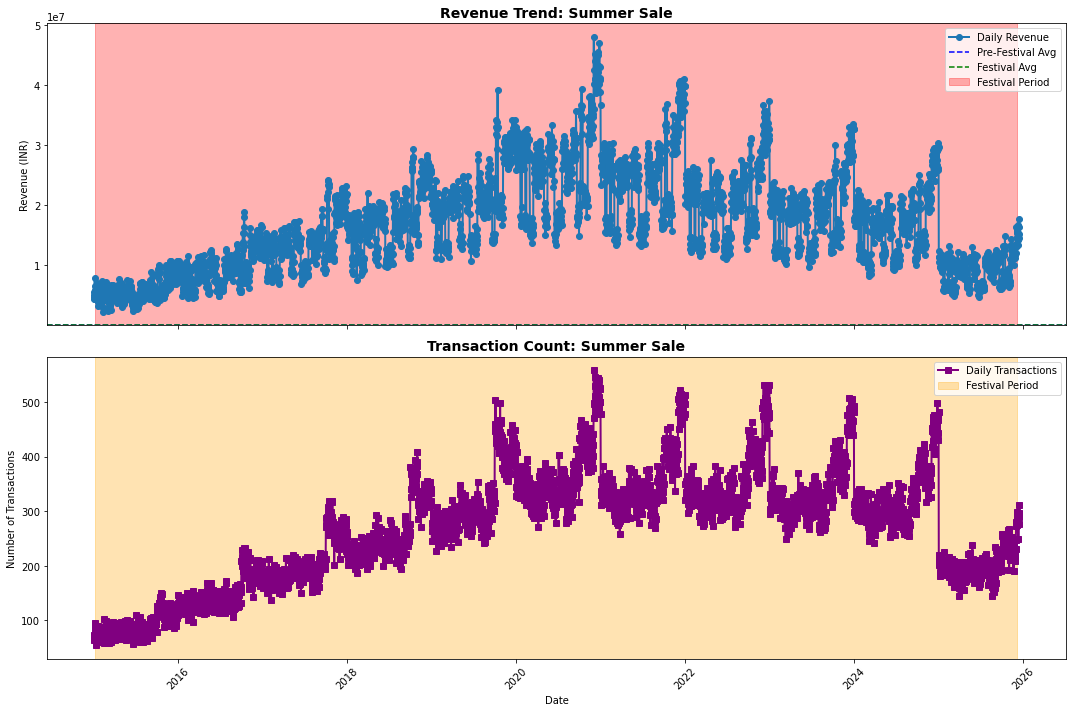


Summer Sale Sales Impact Analysis:
Festival Duration: 3988 days

Revenue Summary:
Before Festival: ₹19,796,887 (1,979,689/day)
During Festival: ₹67,446,740,901 (16,912,422/day)
After Festival: ₹154,610,166 (15,461,017/day)

Impact:
Revenue Boost vs Pre-Festival: +754.3%
Post-Festival Effect vs Pre-Festival: +681.0%




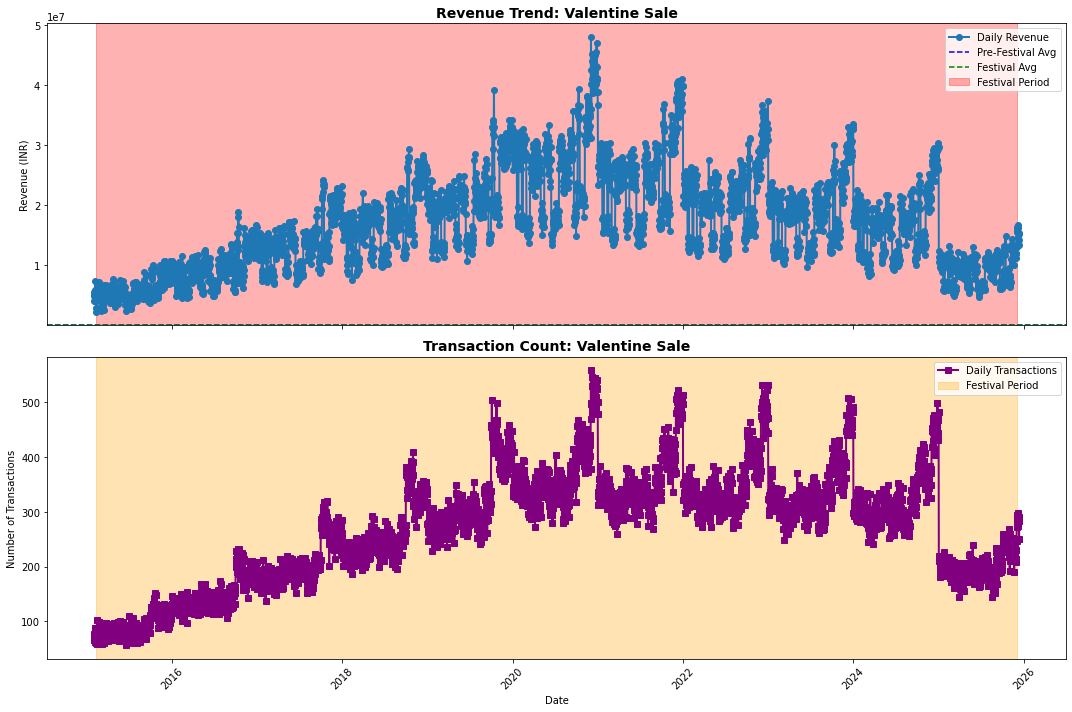


Valentine Sale Sales Impact Analysis:
Festival Duration: 3949 days

Revenue Summary:
Before Festival: ₹53,258,312 (5,325,831/day)
During Festival: ₹67,212,444,206 (17,020,118/day)
After Festival: ₹152,799,952 (15,279,995/day)

Impact:
Revenue Boost vs Pre-Festival: +219.6%
Post-Festival Effect vs Pre-Festival: +186.9%




In [74]:
def festival_sales_analysis(df, festival_name, days_before=10, days_after=10):
    # Ensure order_date is datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Get festival date range
    fest_dates = df[df['festival_name'] == festival_name]['order_date']
    if fest_dates.empty:
        print(f"No data found for festival: {festival_name}")
        return
    
    fest_start = fest_dates.min()
    fest_end = fest_dates.max()
    
    # Create analysis window
    start_date = fest_start - pd.Timedelta(days=days_before)
    end_date = fest_end + pd.Timedelta(days=days_after)
    
    # Filter data within the analysis window
    df_window = df[(df['order_date'] >= start_date) & (df['order_date'] <= end_date)].copy()
    if df_window.empty:
        print(f"No data available for analysis window around {festival_name}")
        return
    
    # Aggregate daily revenue, transactions, and quantity
    daily_stats = df_window.groupby('order_date').agg(
        revenue=('final_amount_inr', 'sum'),
        transactions=('transaction_id', 'count'),
        quantity=('quantity', 'sum')
    ).reset_index()
    
    # Calculate averages
    before_avg = df_window[df_window['order_date'] < fest_start]['final_amount_inr'].mean()
    during_avg = df_window[(df_window['order_date'] >= fest_start) & (df_window['order_date'] <= fest_end)]['final_amount_inr'].mean()
    after_avg = df_window[df_window['order_date'] > fest_end]['final_amount_inr'].mean()

    # Plot daily revenue and transactions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Revenue trend
    ax1.plot(daily_stats['order_date'], daily_stats['revenue'], marker='o', linewidth=2, label='Daily Revenue')
    ax1.axvspan(fest_start, fest_end, color='red', alpha=0.3, label='Festival Period')
    ax1.axhline(y=before_avg, color='blue', linestyle='--', label='Pre-Festival Avg')
    ax1.axhline(y=during_avg, color='green', linestyle='--', label='Festival Avg')
    ax1.set_title(f'Revenue Trend: {festival_name}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Revenue (INR)')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Transaction trend
    ax2.plot(daily_stats['order_date'], daily_stats['transactions'], marker='s', color='purple', linewidth=2, label='Daily Transactions')
    ax2.axvspan(fest_start, fest_end, color='orange', alpha=0.3, label='Festival Period')
    ax2.set_title(f'Transaction Count: {festival_name}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Transactions')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    # Calculate revenue stats
    before_total = df_window[df_window['order_date'] < fest_start]['final_amount_inr'].sum()
    during_total = df_window[(df_window['order_date'] >= fest_start) & (df_window['order_date'] <= fest_end)]['final_amount_inr'].sum()
    after_total = df_window[df_window['order_date'] > fest_end]['final_amount_inr'].sum()
    
    festival_days = (fest_end - fest_start).days + 1
    
    print(f"\n{festival_name} Sales Impact Analysis:")
    print(f"Festival Duration: {festival_days} days")
    print(f"\nRevenue Summary:")
    print(f"Before Festival: ₹{before_total:,.0f} ({before_total/days_before:,.0f}/day)")
    print(f"During Festival: ₹{during_total:,.0f} ({during_total/festival_days:,.0f}/day)")
    print(f"After Festival: ₹{after_total:,.0f} ({after_total/days_after:,.0f}/day)")
    
    print(f"\nImpact:")
    print(f"Revenue Boost vs Pre-Festival: {((during_total/festival_days)/(before_total/days_before)-1)*100:+.1f}%")
    print(f"Post-Festival Effect vs Pre-Festival: {((after_total/days_after)/(before_total/days_before)-1)*100:+.1f}%")
    

# Ensure festival_name is string and fill NaN with 'No_festival'
df['festival_name'] = df['festival_name'].fillna('No_festival').astype(str)

# Analyze all festivals
for fest in sorted(df['festival_name'].unique()):
    if fest != 'No_festival':
        festival_sales_analysis(df, fest)
        print("\n" + "="*80 + "\n")




9 . Analyze customer age group behavior and preferences. Create demographic analysis with category preferences, spending patterns, and shopping frequency across different age segments.


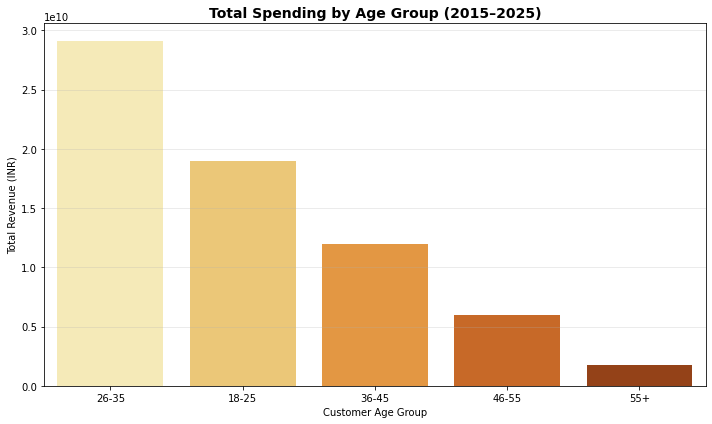

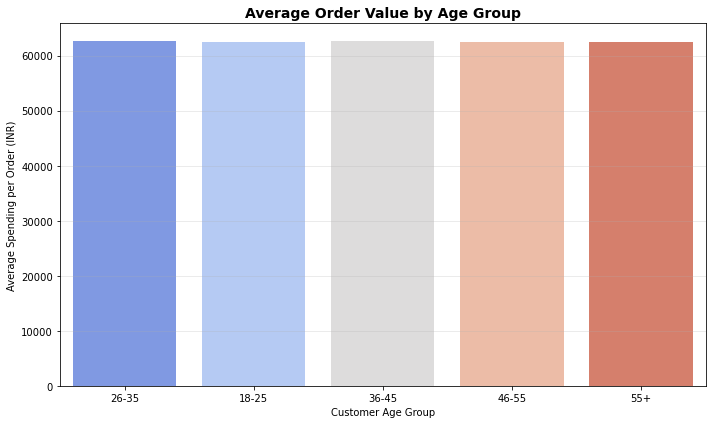

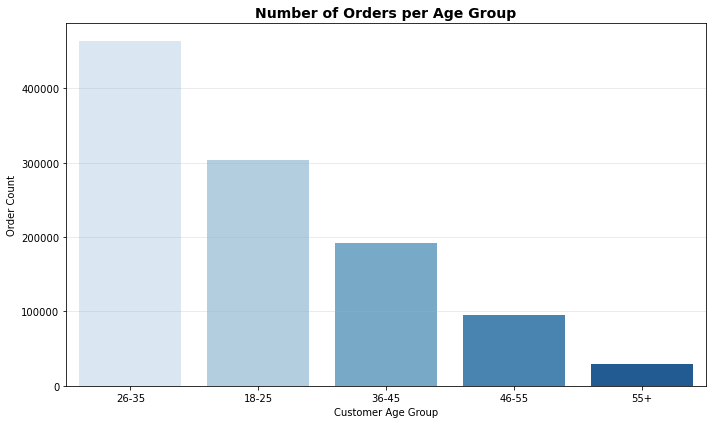

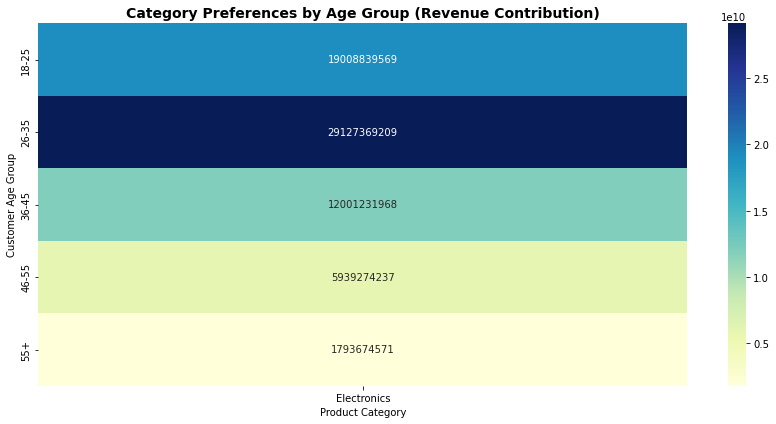

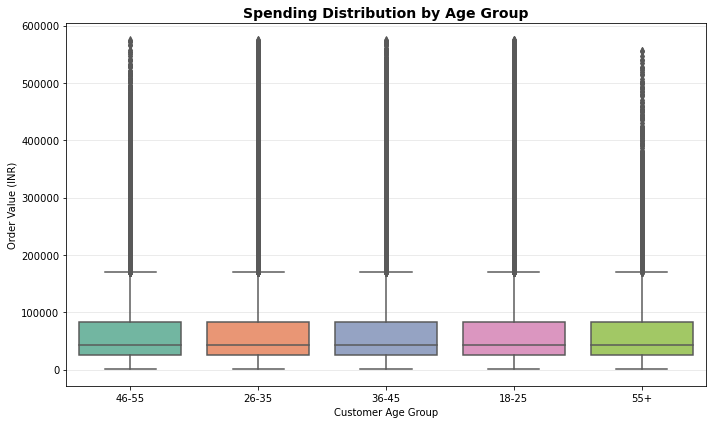

In [43]:
df = df.dropna(subset=['customer_age_group', 'final_amount_inr', 'category'])

# ================================
# 1️⃣ SPENDING PATTERNS BY AGE GROUP
# ================================

spending_stats = df.groupby('customer_age_group')['final_amount_inr'].agg(['mean','sum','count']).reset_index()
spending_stats = spending_stats.sort_values(by='sum', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=spending_stats, x='customer_age_group', y='sum', palette='YlOrBr')
plt.title("Total Spending by Age Group (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Customer Age Group")
plt.ylabel("Total Revenue (INR)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 2️⃣ AVERAGE ORDER VALUE (SPENDING PATTERN)
# ================================

plt.figure(figsize=(10,6))
sns.barplot(data=spending_stats, x='customer_age_group', y='mean', palette='coolwarm')
plt.title("Average Order Value by Age Group", fontsize=14, weight='bold')
plt.xlabel("Customer Age Group")
plt.ylabel("Average Spending per Order (INR)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 3️⃣ SHOPPING FREQUENCY (NUMBER OF ORDERS)
# ================================

plt.figure(figsize=(10,6))
sns.barplot(data=spending_stats, x='customer_age_group', y='count', palette='Blues')
plt.title("Number of Orders per Age Group", fontsize=14, weight='bold')
plt.xlabel("Customer Age Group")
plt.ylabel("Order Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 4️⃣ CATEGORY PREFERENCES BY AGE GROUP (HEATMAP)
# ================================

category_pref = df.groupby(['customer_age_group','category'])['final_amount_inr'].sum().unstack().fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(category_pref, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title("Category Preferences by Age Group (Revenue Contribution)", fontsize=14, weight='bold')
plt.xlabel("Product Category")
plt.ylabel("Customer Age Group")
plt.tight_layout()
plt.show()

# ================================
# 5️⃣ SPENDING DISTRIBUTION (BOX PLOT)
# ================================

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='customer_age_group', y='final_amount_inr', palette='Set2')
plt.title("Spending Distribution by Age Group", fontsize=14, weight='bold')
plt.xlabel("Customer Age Group")
plt.ylabel("Order Value (INR)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

10 . Build price vs demand analysis using scatter plots and correlation matrices. Analyze how pricing strategies affect sales volumes across different categories and customer segments.


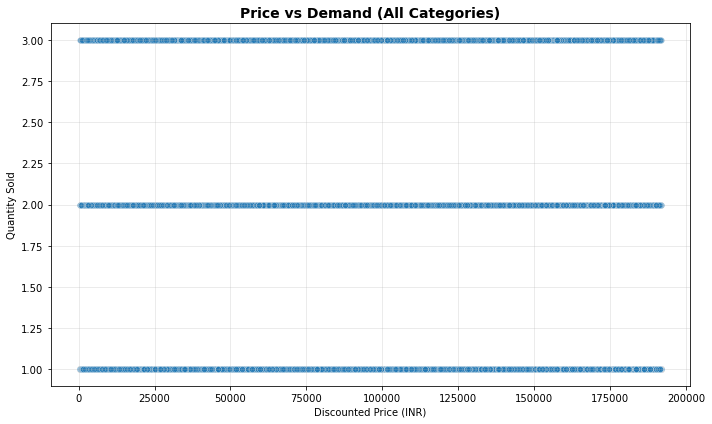

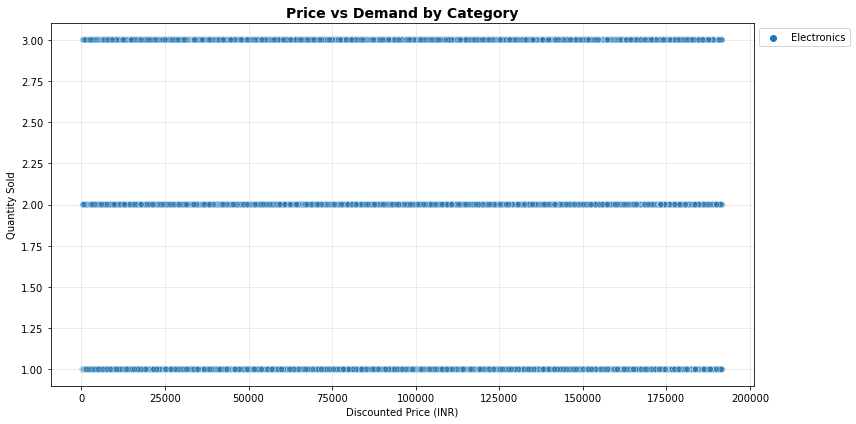

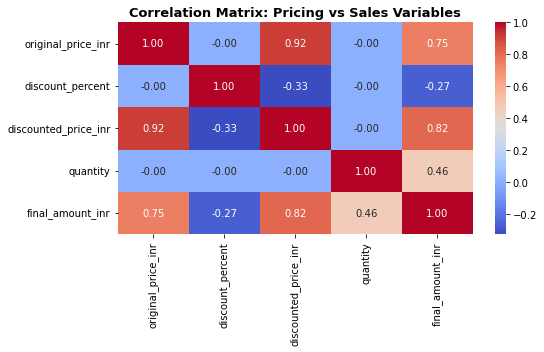

In [73]:
# Clean and ensure numeric data
df['discounted_price_inr'] = pd.to_numeric(df['discounted_price_inr'], errors='coerce')
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df = df.dropna(subset=['discounted_price_inr', 'quantity', 'category'])

# ================================
# 1️⃣ Scatter Plot: Price vs Quantity (Demand Curve)
# ================================

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='discounted_price_inr', y='quantity', alpha=0.4)
plt.title("Price vs Demand (All Categories)", fontsize=14, weight='bold')
plt.xlabel("Discounted Price (INR)")
plt.ylabel("Quantity Sold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 2️⃣ Scatter Plot by Category
# ================================

plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='discounted_price_inr', y='quantity', hue='category', alpha=0.6)
plt.title("Price vs Demand by Category", fontsize=14, weight='bold')
plt.xlabel("Discounted Price (INR)")
plt.ylabel("Quantity Sold")
plt.legend(bbox_to_anchor=(1,1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 3️⃣ Correlation Matrix
# ================================

corr_df = df[['original_price_inr','discount_percent','discounted_price_inr','quantity','final_amount_inr']].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Pricing vs Sales Variables", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()


11 . Create delivery performance analysis showing delivery days distribution, on-time performance, and customer satisfaction correlation with delivery speed across different cities and customer tiers.


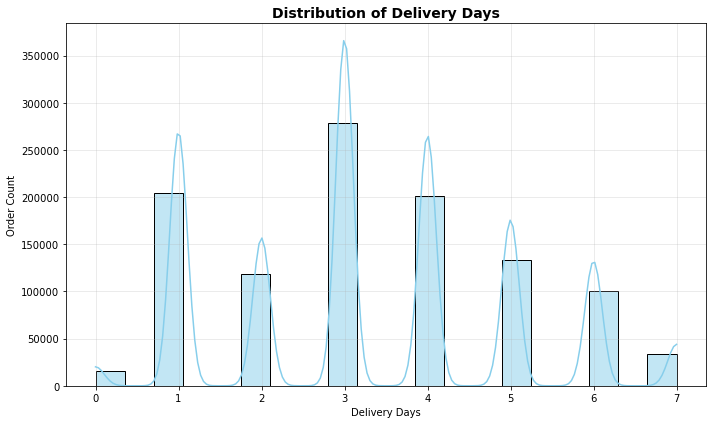

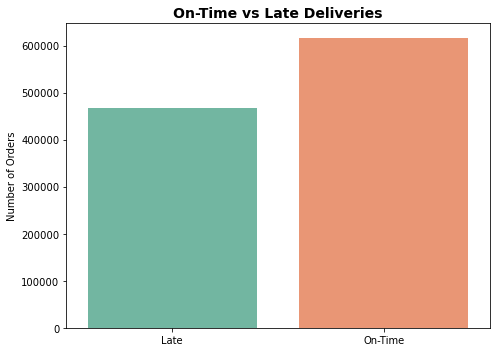

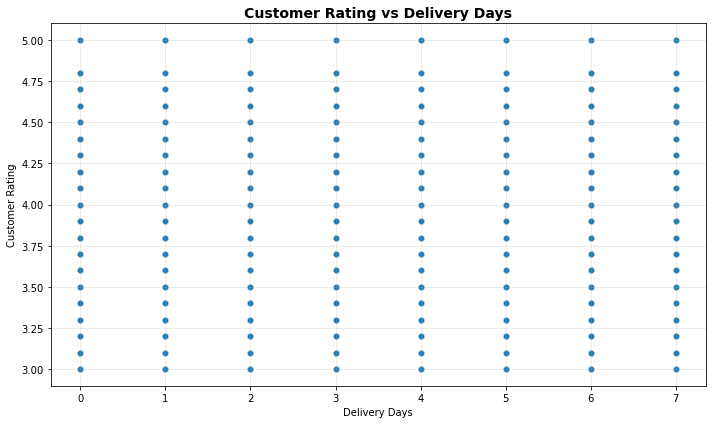

Correlation between Delivery Days and Customer Rating: -0.03


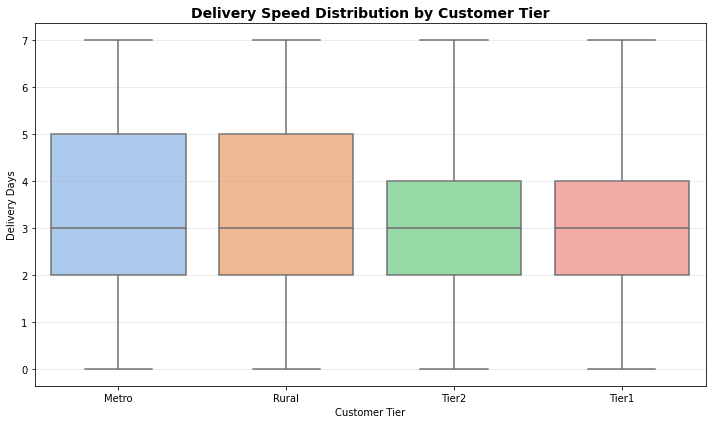

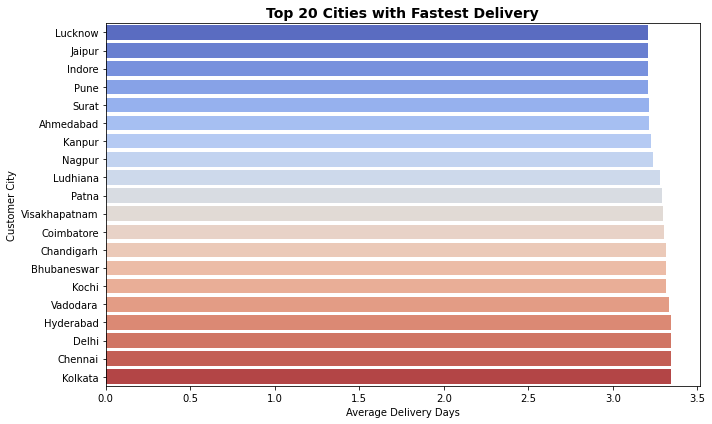

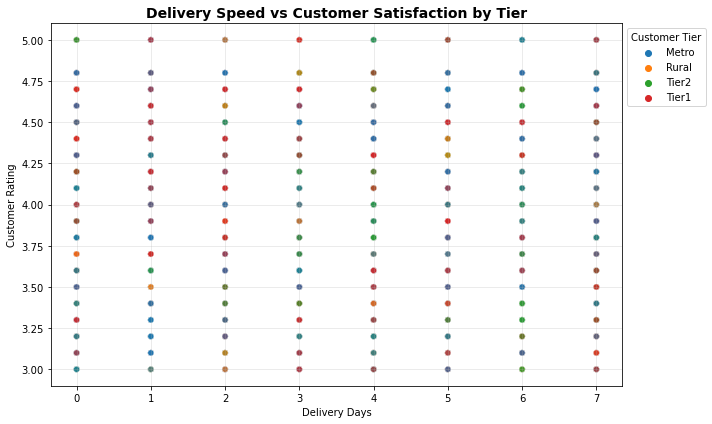

In [45]:
df = df.dropna(subset=['delivery_days','customer_rating','customer_tier','customer_city'])

# ================================
# 1️⃣ Delivery Days Distribution
# ================================

plt.figure(figsize=(10,6))
sns.histplot(df['delivery_days'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Delivery Days", fontsize=14, weight='bold')
plt.xlabel("Delivery Days")
plt.ylabel("Order Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 2️⃣ On-Time vs Late Delivery (Assuming <=3 days is on-time)
# ================================

df['on_time'] = np.where(df['delivery_days'] <= 3, 'On-Time', 'Late')

plt.figure(figsize=(7,5))
sns.countplot(data=df, x='on_time', palette='Set2')
plt.title("On-Time vs Late Deliveries", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

# ================================
# 3️⃣ Delivery Speed vs Customer Rating (Correlation)
# ================================

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='delivery_days', y='customer_rating', alpha=0.5)
plt.title("Customer Rating vs Delivery Days", fontsize=14, weight='bold')
plt.xlabel("Delivery Days")
plt.ylabel("Customer Rating")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr = df[['delivery_days','customer_rating']].corr().iloc[0,1]
print(f"Correlation between Delivery Days and Customer Rating: {corr:.2f}")

# ================================
# 4️⃣ Delivery Performance by City Tier
# ================================

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='customer_tier', y='delivery_days', palette='pastel')
plt.title("Delivery Speed Distribution by Customer Tier", fontsize=14, weight='bold')
plt.xlabel("Customer Tier")
plt.ylabel("Delivery Days")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ================================
# 5️⃣ Average Delivery Time by City
# ================================

city_delivery = df.groupby('customer_city')['delivery_days'].mean().sort_values(ascending=True).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=city_delivery.values, y=city_delivery.index, palette='coolwarm')
plt.title("Top 20 Cities with Fastest Delivery", fontsize=14, weight='bold')
plt.xlabel("Average Delivery Days")
plt.ylabel("Customer City")
plt.tight_layout()
plt.show()

# ================================
# 6️⃣ Delivery vs Satisfaction by Customer Tier
# ================================

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='delivery_days', y='customer_rating', hue='customer_tier', alpha=0.6)
plt.title("Delivery Speed vs Customer Satisfaction by Tier", fontsize=14, weight='bold')
plt.xlabel("Delivery Days")
plt.ylabel("Customer Rating")
plt.legend(title='Customer Tier', bbox_to_anchor=(1,1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

12 . Analyze return patterns and customer satisfaction using return rates, reasons, and correlation with product ratings, prices, and categories through multiple visualization techniques.


Overall return rate: 7.08%


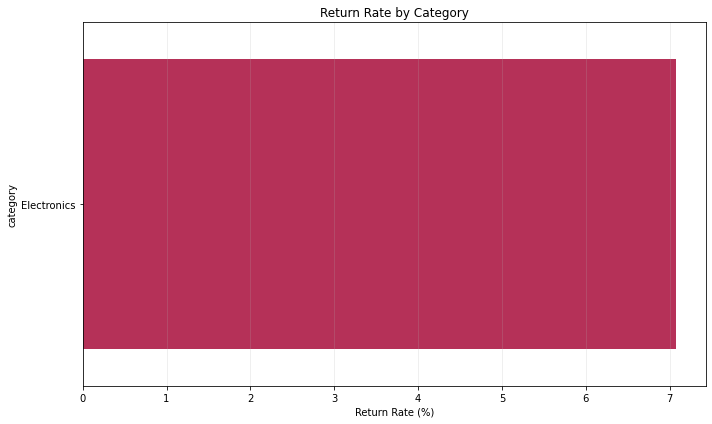

Column 'return_reason' not found — skipping top reasons chart.


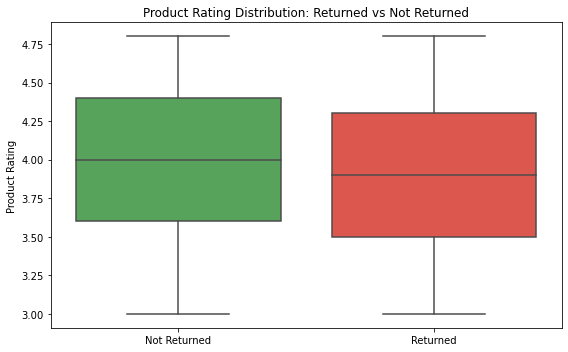

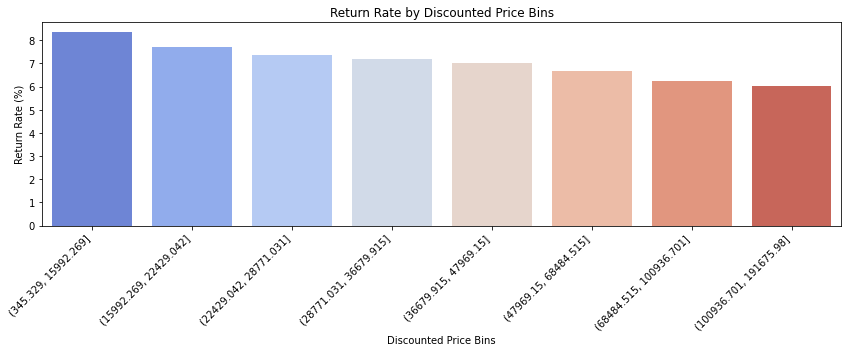

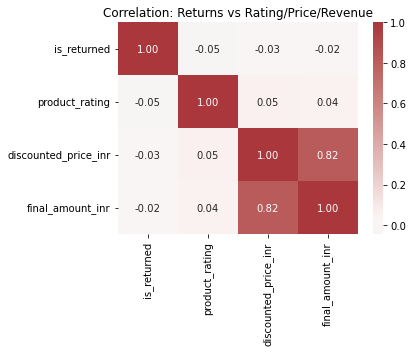

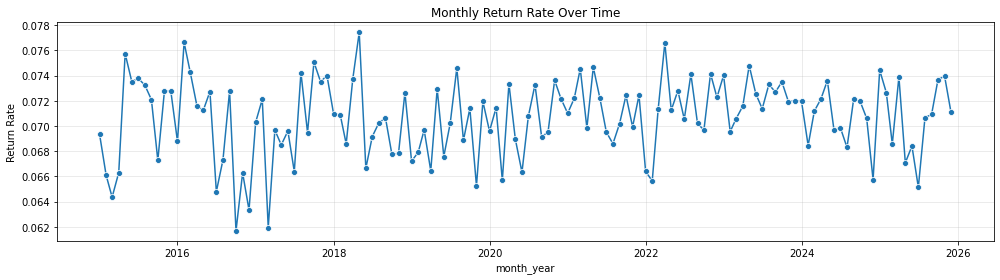

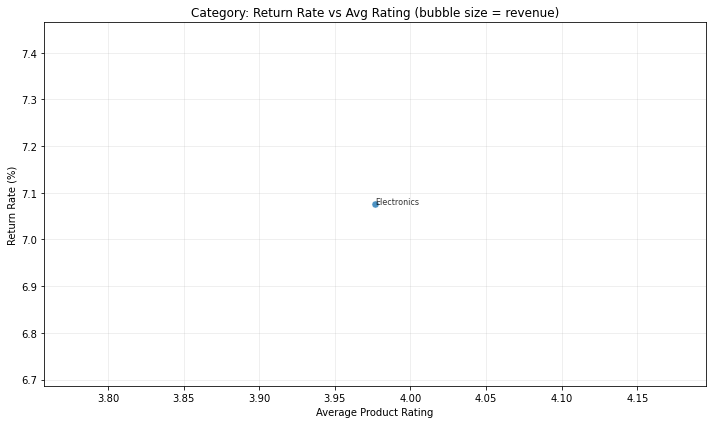

In [46]:

# Convert date and numeric columns
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['final_amount_inr'] = pd.to_numeric(df['final_amount_inr'], errors='coerce')
df['discounted_price_inr'] = pd.to_numeric(df.get('discounted_price_inr', df.get('final_amount_inr')), errors='coerce')
df['product_rating'] = pd.to_numeric(df.get('product_rating'), errors='coerce')

# Standardize return flag (robust to different value formats)
df['return_status'] = df['return_status'].astype(str)
df['is_returned'] = df['return_status'].str.lower().str.contains(r'return|yes|true|y|1', na=False).astype(int)

# Drop rows missing key columns for this analysis
df_returns = df.dropna(subset=['is_returned','final_amount_inr','product_rating','category'])

# 1) Overall return rate
overall_return_rate = df_returns['is_returned'].mean() * 100
print(f"Overall return rate: {overall_return_rate:.2f}%")

# 2) Return rate by category
cat_return = df_returns.groupby('category')['is_returned'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(10,6))
sns.barplot(x=cat_return.values, y=cat_return.index, palette='rocket')
plt.xlabel("Return Rate (%)")
plt.title("Return Rate by Category")
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

# 3) Top return reasons (if available)
if 'return_reason' in df.columns:
    rr = df_returns[df_returns['is_returned']==1]['return_reason'].fillna('Unknown')
    rr_counts = rr.value_counts().head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=rr_counts.values, y=rr_counts.index, palette='magma')
    plt.xlabel("Number of Returns")
    plt.title("Top Return Reasons (Top 15)")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'return_reason' not found — skipping top reasons chart.")

# 4) Returned vs Non-returned: product rating distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=df_returns, x='is_returned', y='product_rating', palette=['#4CAF50','#F44336'])
plt.xticks([0,1], ['Not Returned','Returned'])
plt.xlabel("")
plt.ylabel("Product Rating")
plt.title("Product Rating Distribution: Returned vs Not Returned")
plt.tight_layout()
plt.show()

# 5) Return probability vs discounted price (binned)
df_price_bins = df_returns.copy()
df_price_bins['price_bin'] = pd.qcut(df_price_bins['discounted_price_inr'].fillna(0)+1, q=8, duplicates='drop')
price_bin_return = df_price_bins.groupby('price_bin')['is_returned'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.barplot(x=price_bin_return['price_bin'].astype(str), y=price_bin_return['is_returned']*100, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Return Rate (%)")
plt.xlabel("Discounted Price Bins")
plt.title("Return Rate by Discounted Price Bins")
plt.tight_layout()
plt.show()

# 6) Correlation between return flag and rating/price/revenue
corr_df = df_returns[['is_returned','product_rating','discounted_price_inr','final_amount_inr']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation: Returns vs Rating/Price/Revenue")
plt.tight_layout()
plt.show()

# 7) Return rate over time (monthly)
df_returns['month_year'] = df_returns['order_date'].dt.to_period('M')
monthly_returns = df_returns.groupby('month_year')['is_returned'].mean().reset_index()
monthly_returns['month_year'] = monthly_returns['month_year'].dt.to_timestamp()
plt.figure(figsize=(14,4))
sns.lineplot(data=monthly_returns, x='month_year', y='is_returned', marker='o')
plt.ylabel("Return Rate")
plt.title("Monthly Return Rate Over Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8) Return rate by category vs average product rating (scatter)
cat_metrics = df_returns.groupby('category').agg(
    return_rate = ('is_returned', 'mean'),
    avg_rating = ('product_rating', 'mean'),
    revenue = ('final_amount_inr', 'sum')
).reset_index()
cat_metrics['return_rate_pct'] = cat_metrics['return_rate'] * 100
plt.figure(figsize=(10,6))
sns.scatterplot(data=cat_metrics, x='avg_rating', y='return_rate_pct', size='revenue', sizes=(50,400), legend=False, alpha=0.8)
for i, r in cat_metrics.iterrows():
    plt.text(r['avg_rating'], r['return_rate_pct'], r['category'], fontsize=8, alpha=0.8)
plt.xlabel("Average Product Rating")
plt.ylabel("Return Rate (%)")
plt.title("Category: Return Rate vs Avg Rating (bubble size = revenue)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


13 . Study brand performance and market share evolution. Create brand comparison charts, market share trends, and competitive positioning analysis across different categories.


<Figure size 1008x432 with 0 Axes>

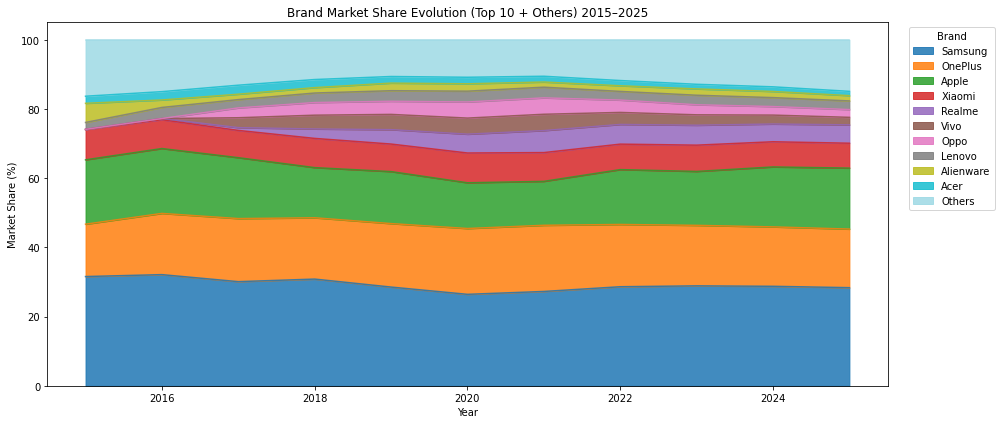

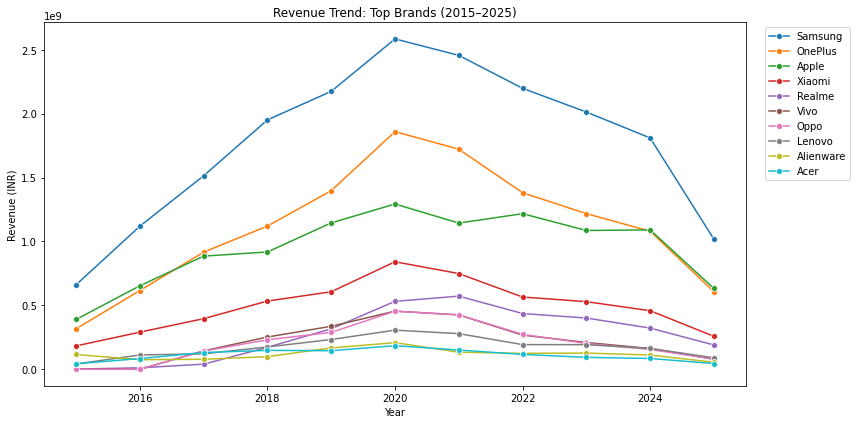

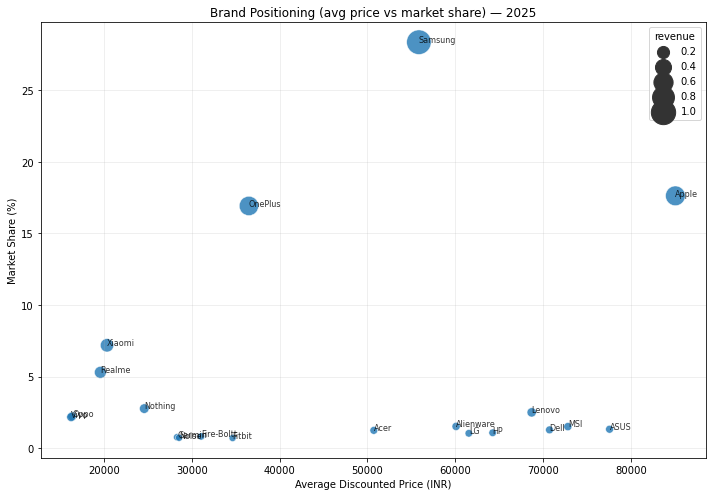

Brand market share pivot (years x brands):
brand       Acer  Alienware  Apple  Lenovo  OnePlus  Oppo  Others  Realme  \
order_year                                                                  
2015        2.05       5.53  18.61    2.00    15.12  0.00   16.33    0.07   
2016        2.41       2.15  18.75    3.21    17.68  0.00   15.00    0.33   
2017        2.60       1.56  17.60    2.41    18.22  2.83   13.14    0.80   
2018        2.34       1.56  14.51    2.76    17.71  3.65   11.51    2.72   
2019        1.91       2.19  15.03    3.06    18.33  3.79   10.63    4.15   

brand       Samsung  Vivo  Xiaomi  
order_year                         
2015          31.57  0.00    8.74  
2016          32.12  0.00    8.33  
2017          30.10  2.87    7.88  
2018          30.84  3.99    8.44  
2019          28.53  4.41    7.96  


In [47]:

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['order_year'] = df['order_date'].dt.year
df['final_amount_inr'] = pd.to_numeric(df['final_amount_inr'], errors='coerce')

# Filter years 2015-2025 if present
df = df[df['order_year'].between(2015,2025)]

# 1) Yearly revenue by brand (wide format)
brand_year = df.groupby(['order_year','brand'])['final_amount_inr'].sum().unstack(fill_value=0)

# 2) Top N brands by total revenue during period for focused plots
top_brands = df.groupby('brand')['final_amount_inr'].sum().nlargest(10).index.tolist()

# 3) Stacked area: market share of top brands (others aggregated)
brand_year_top = brand_year[top_brands].copy()
brand_year_top['Others'] = brand_year.drop(columns=top_brands, errors='ignore').sum(axis=1)
brand_year_top_pct = brand_year_top.div(brand_year_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14,6))
brand_year_top_pct.plot(kind='area', stacked=True, figsize=(14,6), colormap='tab20', alpha=0.85)
plt.title("Brand Market Share Evolution (Top 10 + Others) 2015–2025")
plt.ylabel("Market Share (%)")
plt.xlabel("Year")
plt.legend(title="Brand", bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) Brand comparison: revenue trend lines for top brands
plt.figure(figsize=(12,6))
for b in top_brands:
    sns.lineplot(data=brand_year[b], marker='o', label=b)
plt.title("Revenue Trend: Top Brands (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Revenue (INR)")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# 5) Competitive positioning: avg price vs market share scatter (latest year)
latest_year = df['order_year'].max()
brand_latest = df[df['order_year']==latest_year].groupby('brand').agg(
    revenue = ('final_amount_inr','sum'),
    avg_price = ('discounted_price_inr','mean'),
    volume = ('quantity','sum') if 'quantity' in df.columns else ('final_amount_inr','count')
).reset_index()
brand_latest['market_share_pct'] = brand_latest['revenue'] / brand_latest['revenue'].sum() * 100

# Keep top brands for clarity
bl = brand_latest.sort_values('revenue', ascending=False).head(20)

plt.figure(figsize=(10,7))
sns.scatterplot(data=bl, x='avg_price', y='market_share_pct', size='revenue', sizes=(50,600), alpha=0.8)
for i, r in bl.iterrows():
    plt.text(r['avg_price'], r['market_share_pct'], r['brand'], fontsize=8, alpha=0.8)
plt.xlabel("Average Discounted Price (INR)")
plt.ylabel("Market Share (%)")
plt.title(f"Brand Positioning (avg price vs market share) — {latest_year}")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# 6) Brand share table (top brands over the years) — quick tabular view
brand_share_table = (brand_year_top_pct.reset_index().melt(id_vars='order_year', var_name='brand', value_name='market_share_pct'))
brand_share_pivot = brand_share_table.pivot(index='order_year', columns='brand', values='market_share_pct').fillna(0)
print("Brand market share pivot (years x brands):")
print(brand_share_pivot.round(2).head())


14 . Build customer lifetime value (CLV) analysis using cohort analysis, retention curves, and CLV distribution across different customer segments and acquisition years.


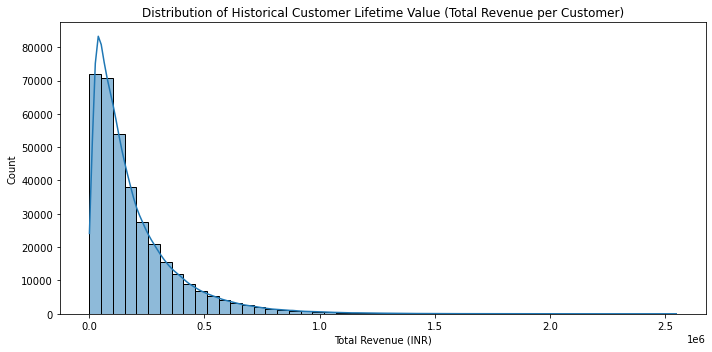

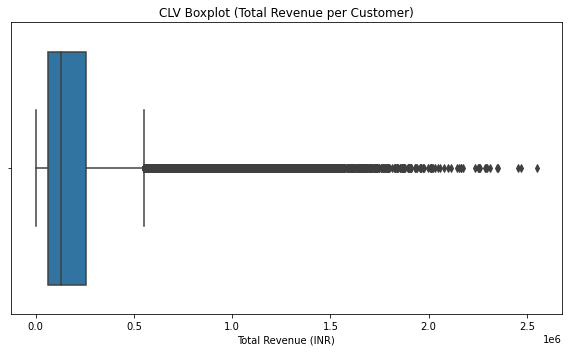

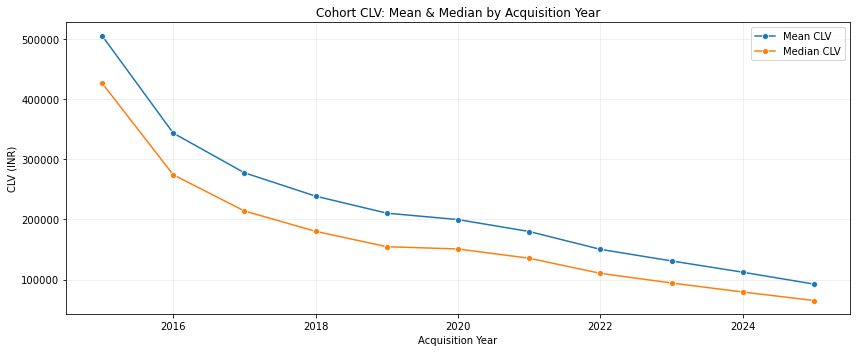

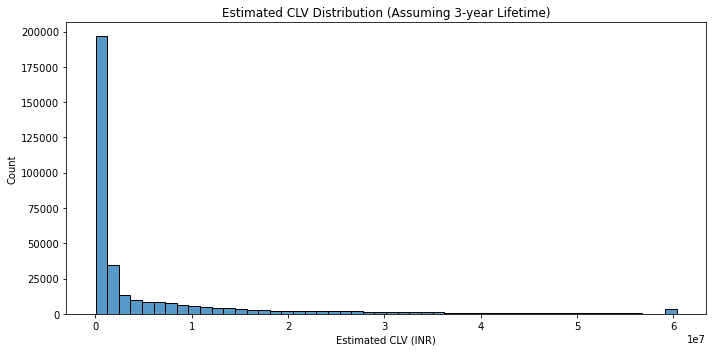

Median retention at 0 months: 100.00%
Median retention at 1 months: 11.34%
Median retention at 3 months: 11.31%
Median retention at 6 months: 10.29%
Median retention at 12 months: 2.60%
Average CLV by Acquisition Year:
    acquisition_year  avg_total_revenue  avg_est_clv
0               2015          505428.01    663394.58
1               2016          343445.38   2246942.82
2               2017          277453.45   3813160.47
3               2018          238647.47   5041542.88
4               2019          210373.39   5962124.51
5               2020          199693.48   7511135.27
6               2021          179876.16   7426273.72
7               2022          150231.42   6741700.02
8               2023          130960.62   7213885.42
9               2024          112242.87   7567801.59
10              2025           92460.70   7186765.65


C:\Users\SATHIS~1\AppData\Local\Temp/ipykernel_3680/485859049.py:83: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_clv_by_year = cust_span.reset_index().merge(df.groupby('customer_id')['acquisition_year'].first().reset_index(), on='customer_id').groupby('acquisition_year')['total_revenue','est_clv'].mean().reset_index()


In [49]:

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['final_amount_inr'] = pd.to_numeric(df['final_amount_inr'], errors='coerce')

# Create acquisition year/month for each customer (first purchase)
df['acquisition_year'] = df.groupby('customer_id')['order_date'].transform('min').dt.year
df['acquisition_month'] = df.groupby('customer_id')['order_date'].transform('min').dt.to_period('M')
df['order_month'] = df['order_date'].dt.to_period('M')
df['order_year'] = df['order_date'].dt.year

# 1) Cohort retention matrix (by acquisition_month)
cohort_data = df[['customer_id','order_month','acquisition_month']].drop_duplicates()
cohort_counts = cohort_data.groupby(['acquisition_month','order_month'])['customer_id'].nunique().reset_index()

# Convert periods to integer month offset
cohort_counts['acq_period'] = cohort_counts['acquisition_month'].dt.to_timestamp()
cohort_counts['ord_period'] = cohort_counts['order_month'].dt.to_timestamp()
cohort_counts['period_index'] = ((cohort_counts['ord_period'].dt.year - cohort_counts['acq_period'].dt.year) * 12 +
                                 (cohort_counts['ord_period'].dt.month - cohort_counts['acq_period'].dt.month))

cohort_pivot = cohort_counts.pivot_table(index='acquisition_month', columns='period_index', values='customer_id').fillna(0)



#  Historical CLV per customer (simple empirical CLV = total revenue per customer)
clv = df.groupby('customer_id')['final_amount_inr'].sum().reset_index().rename(columns={'final_amount_inr':'total_revenue'})
clv['orders_count'] = df.groupby('customer_id')['order_date'].count().values
clv['avg_order_value'] = clv['total_revenue'] / clv['orders_count']

# Distribution of CLV
plt.figure(figsize=(10,5))
sns.histplot(clv['total_revenue'], bins=50, kde=True)
plt.title("Distribution of Historical Customer Lifetime Value (Total Revenue per Customer)")
plt.xlabel("Total Revenue (INR)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=clv['total_revenue'])
plt.title("CLV Boxplot (Total Revenue per Customer)")
plt.xlabel("Total Revenue (INR)")
plt.tight_layout()
plt.show()

#  CLV by acquisition year (avg CLV per cohort)
clv_with_acq = df.groupby(['customer_id','acquisition_year'])['final_amount_inr'].sum().reset_index().groupby('acquisition_year')['final_amount_inr'].agg(['mean','median','sum','count']).reset_index()
clv_with_acq = clv_with_acq.sort_values('acquisition_year')

plt.figure(figsize=(12,5))
sns.lineplot(data=clv_with_acq, x='acquisition_year', y='mean', marker='o', label='Mean CLV')
sns.lineplot(data=clv_with_acq, x='acquisition_year', y='median', marker='o', label='Median CLV')
plt.title("Cohort CLV: Mean & Median by Acquisition Year")
plt.xlabel("Acquisition Year")
plt.ylabel("CLV (INR)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# 4) Simple predictive-ish CLV estimate: average annual revenue * expected lifespan
# Compute active years per customer
cust_span = df.groupby('customer_id').agg(first_order=('order_date','min'), last_order=('order_date','max'), total_revenue=('final_amount_inr','sum'))
cust_span['active_years'] = ((cust_span['last_order'] - cust_span['first_order']).dt.days / 365.25).clip(lower=0.01)
cust_span['annual_revenue'] = cust_span['total_revenue'] / cust_span['active_years']

# Choose an expected_lifespan (years) — here we use 3 as a business assumption; change as needed
expected_lifespan = 3
cust_span['est_clv'] = cust_span['annual_revenue'] * expected_lifespan

plt.figure(figsize=(10,5))
sns.histplot(cust_span['est_clv'].clip(upper=cust_span['est_clv'].quantile(0.99)), bins=50, kde=False)
plt.title(f"Estimated CLV Distribution (Assuming {expected_lifespan}-year Lifetime)")
plt.xlabel("Estimated CLV (INR)")
plt.tight_layout()
plt.show()

# 5) Retention curve (cohort aggregated): percent retained after 0,1,3,6,12 months
retention_summary = cohort_retention.copy()
for m in [0,1,3,6,12]:
    if m in retention_summary.columns:
        print(f"Median retention at {m} months: {retention_summary[m].median():.2%}")

# 6) Table: average CLV per acquisition year (for export / reporting)
avg_clv_by_year = cust_span.reset_index().merge(df.groupby('customer_id')['acquisition_year'].first().reset_index(), on='customer_id').groupby('acquisition_year')['total_revenue','est_clv'].mean().reset_index()
avg_clv_by_year.columns = ['acquisition_year','avg_total_revenue','avg_est_clv']
print("Average CLV by Acquisition Year:")
print(avg_clv_by_year.sort_values('acquisition_year').round(2))


15 . Analyze discount and promotional effectiveness. Create discount impact analysis showing correlation between discount percentages, sales volumes, and revenue across categories and time periods.


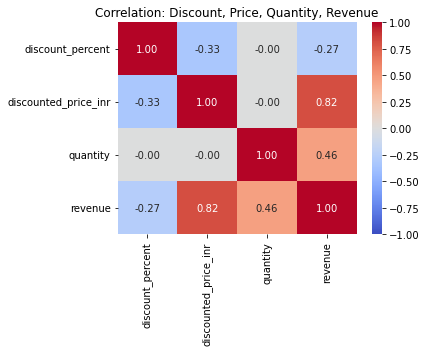

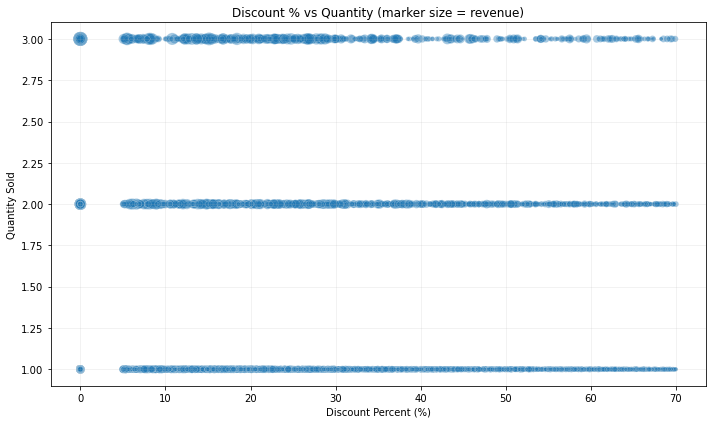

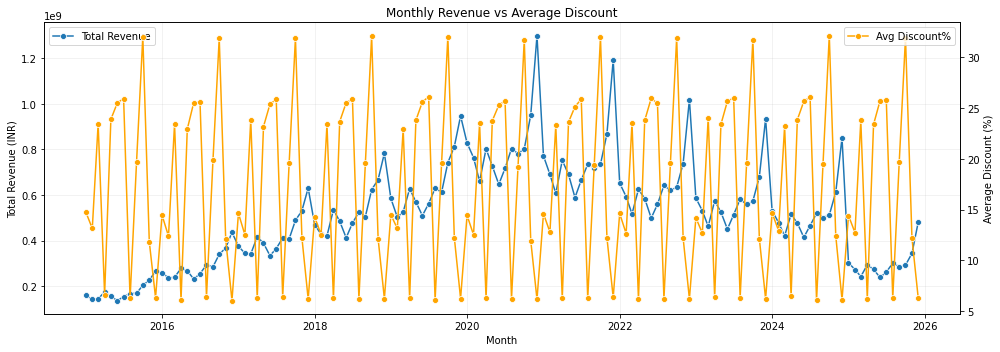

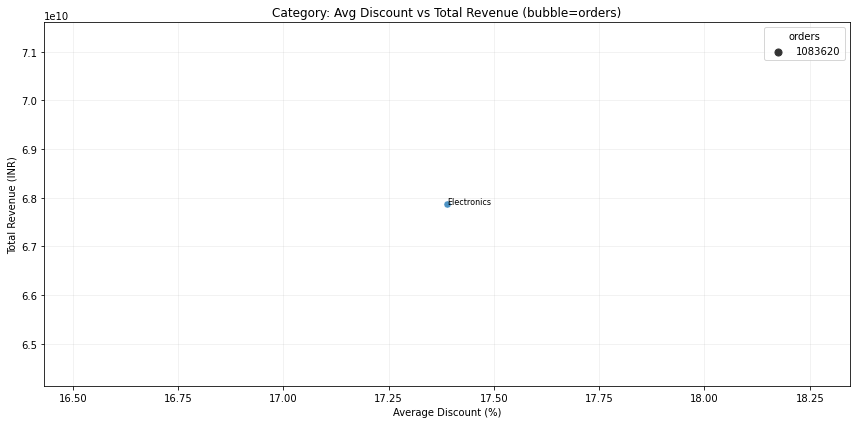

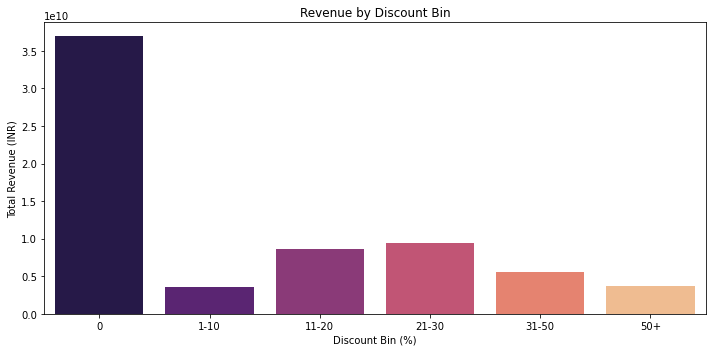

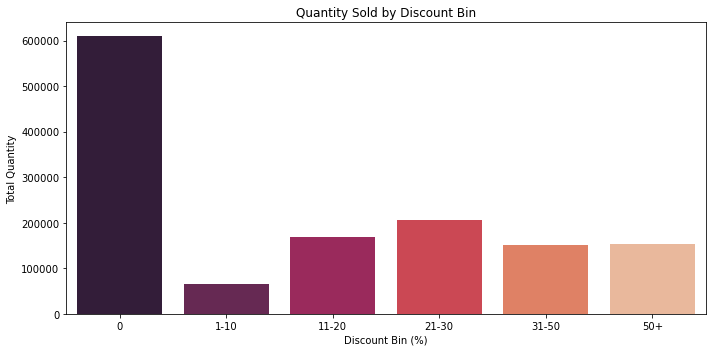

In [51]:


# Basic datetime + numeric conversions
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
df['discount_percent'] = pd.to_numeric(df.get('discount_percent'), errors='coerce')
df['discounted_price_inr'] = pd.to_numeric(df.get('discounted_price_inr'), errors='coerce')
df['original_price_inr'] = pd.to_numeric(df.get('original_price_inr'), errors='coerce')
df['quantity'] = pd.to_numeric(df.get('quantity'), errors='coerce')
df['final_amount_inr'] = pd.to_numeric(df.get('final_amount_inr'), errors='coerce')
df['product_rating'] = pd.to_numeric(df.get('product_rating'), errors='coerce')

# Ensure revenue column (fallback to discounted_price * quantity if final_amount missing)
df['calculated_revenue'] = df['discounted_price_inr'] * df['quantity']
df['revenue'] = df['final_amount_inr'].fillna(df['calculated_revenue'])

# Drop rows without essential numeric info for the analyses below
df_clean = df.dropna(subset=['discount_percent','discounted_price_inr','quantity','revenue']).copy()



# 1) Correlations between discount percent, quantity, revenue
corr_cols = ['discount_percent','discounted_price_inr','quantity','revenue']
corr_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation: Discount, Price, Quantity, Revenue")
plt.tight_layout()
plt.show()

# 2) Scatter: Discount % vs Quantity (with revenue as marker size) — overall
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean.sample(frac=min(1,20000/len(df_clean))), x='discount_percent', y='quantity',
                size='revenue', sizes=(10,200), alpha=0.4, hue='category', legend=False)
plt.xlabel("Discount Percent (%)")
plt.ylabel("Quantity Sold")
plt.title("Discount % vs Quantity (marker size = revenue)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 3) Time-series: Monthly average discount vs monthly revenue (dual axis)
monthly = df_clean.groupby('order_month').agg(
    avg_discount = ('discount_percent','mean'),
    total_revenue = ('revenue','sum'),
    total_quantity = ('quantity','sum')
).reset_index().dropna()

fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
sns.lineplot(data=monthly, x='order_month', y='total_revenue', ax=ax1, marker='o', label='Total Revenue')
sns.lineplot(data=monthly, x='order_month', y='avg_discount', ax=ax2, marker='o', color='orange', label='Avg Discount%')
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Revenue (INR)")
ax2.set_ylabel("Average Discount (%)")
ax1.set_title("Monthly Revenue vs Average Discount")
ax1.grid(alpha=0.2)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 4) Category-wise impact: average discount and revenue uplift
cat_summary = df_clean.groupby('category').agg(
    avg_discount = ('discount_percent','mean'),
    total_revenue = ('revenue','sum'),
    avg_quantity = ('quantity','mean'),
    orders = ('revenue','count')
).sort_values('total_revenue', ascending=False).reset_index()

plt.figure(figsize=(12,6))
sns.scatterplot(data=cat_summary, x='avg_discount', y='total_revenue', size='orders', sizes=(50,600), alpha=0.8)
for i, r in cat_summary.iterrows():
    plt.text(r['avg_discount'], r['total_revenue'], r['category'], fontsize=8)
plt.xlabel("Average Discount (%)")
plt.ylabel("Total Revenue (INR)")
plt.title("Category: Avg Discount vs Total Revenue (bubble=orders)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 5) Discount bins: examine revenue and quantity by discount bins
df_clean['discount_bin'] = pd.cut(df_clean['discount_percent'], bins=[-1,0,10,20,30,50,100], labels=['0','1-10','11-20','21-30','31-50','50+'])
disc_bin_summary = df_clean.groupby('discount_bin').agg(total_revenue=('revenue','sum'), total_qty=('quantity','sum'), orders=('revenue','count')).reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=disc_bin_summary, x='discount_bin', y='total_revenue', palette='magma')
plt.title("Revenue by Discount Bin")
plt.xlabel("Discount Bin (%)")
plt.ylabel("Total Revenue (INR)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=disc_bin_summary, x='discount_bin', y='total_qty', palette='rocket')
plt.title("Quantity Sold by Discount Bin")
plt.xlabel("Discount Bin (%)")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()


16 . Study product rating patterns and their impact on sales. Analyze rating distributions, correlation with sales performance, and identify patterns across categories and price ranges.


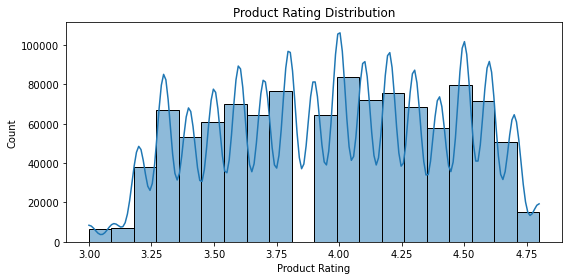

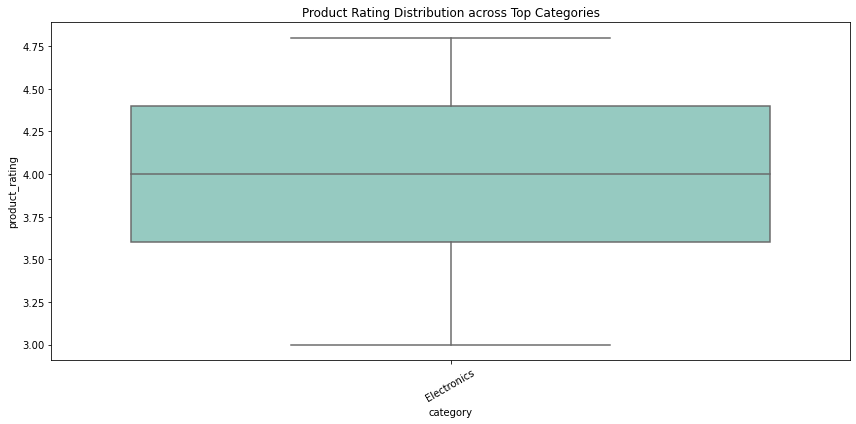

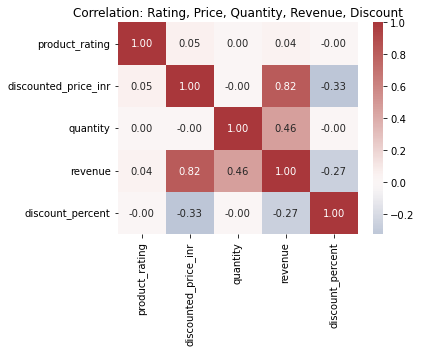

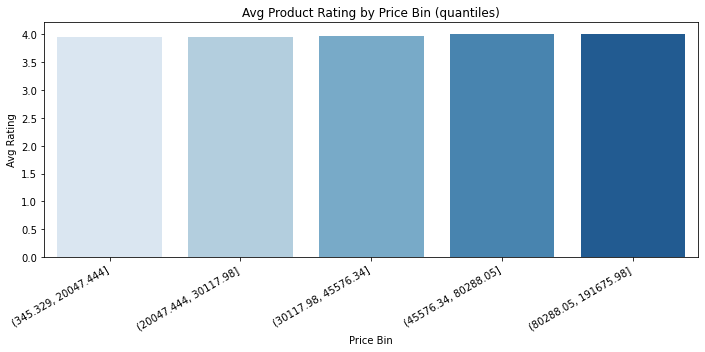

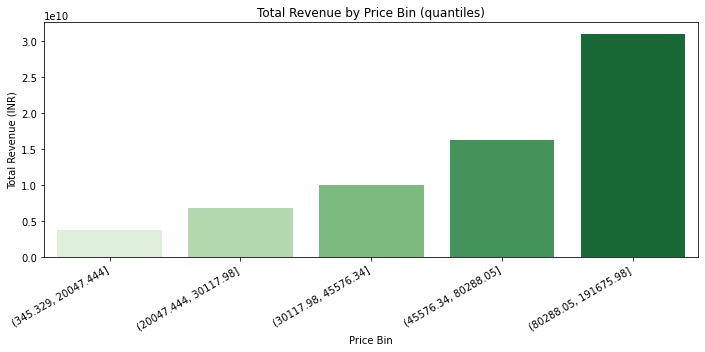

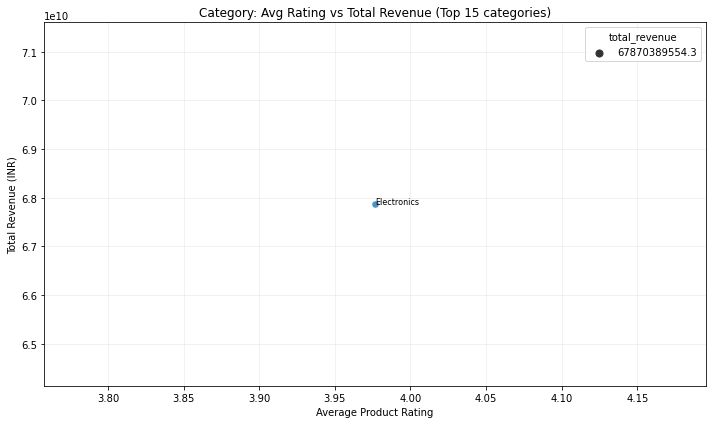

In [52]:

df_rating = df.dropna(subset=['product_rating','revenue','discounted_price_inr','category']).copy()

# 1) Rating distribution overall
plt.figure(figsize=(8,4))
sns.histplot(df_rating['product_rating'], bins=20, kde=True)
plt.title("Product Rating Distribution")
plt.xlabel("Product Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Rating distribution by category (boxplot) - top categories only to keep plot readable
top_cats = df_rating['category'].value_counts().head(8).index
plt.figure(figsize=(12,6))
sns.boxplot(data=df_rating[df_rating['category'].isin(top_cats)], x='category', y='product_rating', palette='Set3')
plt.xticks(rotation=30)
plt.title("Product Rating Distribution across Top Categories")
plt.tight_layout()
plt.show()

# 3) Correlation matrix including rating, price, quantity, revenue
rating_corr_cols = ['product_rating','discounted_price_inr','quantity','revenue','discount_percent']
rating_corr = df_rating[rating_corr_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(rating_corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation: Rating, Price, Quantity, Revenue, Discount")
plt.tight_layout()
plt.show()

# 4) Price range bins vs avg rating and sales
df_rating['price_bin'] = pd.qcut(df_rating['discounted_price_inr'].fillna(0)+1, q=5, duplicates='drop')
price_bin_stats = df_rating.groupby('price_bin').agg(avg_rating=('product_rating','mean'), total_revenue=('revenue','sum'), avg_quantity=('quantity','mean')).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=price_bin_stats, x=price_bin_stats['price_bin'].astype(str), y='avg_rating', palette='Blues')
plt.xticks(rotation=30, ha='right')
plt.title("Avg Product Rating by Price Bin (quantiles)")
plt.xlabel("Price Bin")
plt.ylabel("Avg Rating")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=price_bin_stats, x=price_bin_stats['price_bin'].astype(str), y='total_revenue', palette='Greens')
plt.xticks(rotation=30, ha='right')
plt.title("Total Revenue by Price Bin (quantiles)")
plt.xlabel("Price Bin")
plt.ylabel("Total Revenue (INR)")
plt.tight_layout()
plt.show()

# 5) Scatter: Product Rating vs Revenue (by category), annotate categories with high revenue
cat_rating_rev = df_rating.groupby('category').agg(avg_rating=('product_rating','mean'), total_revenue=('revenue','sum')).reset_index().sort_values('total_revenue', ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.scatterplot(data=cat_rating_rev, x='avg_rating', y='total_revenue', size='total_revenue', sizes=(50,600), alpha=0.8)
for i,r in cat_rating_rev.iterrows():
    plt.text(r['avg_rating'], r['total_revenue'], r['category'], fontsize=8)
plt.xlabel("Average Product Rating")
plt.ylabel("Total Revenue (INR)")
plt.title("Category: Avg Rating vs Total Revenue (Top 15 categories)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

17. Create customer journey analysis showing purchase frequency patterns, category transitions, and customer evolution from first purchase to loyal customers using flow diagrams and transition matrices.


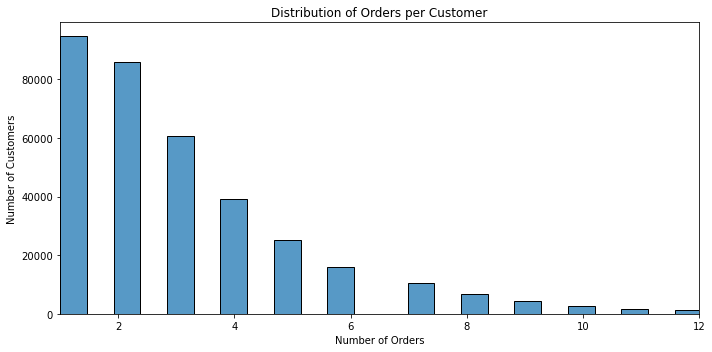

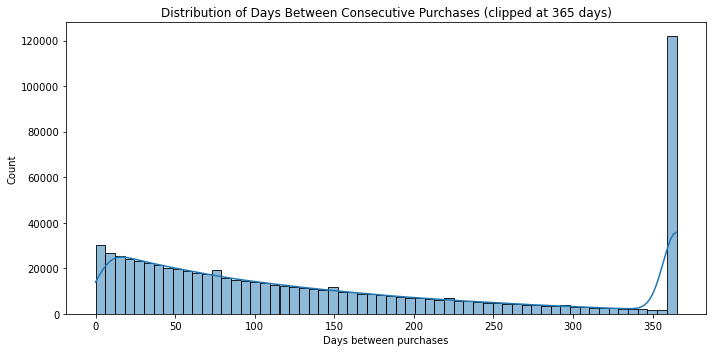

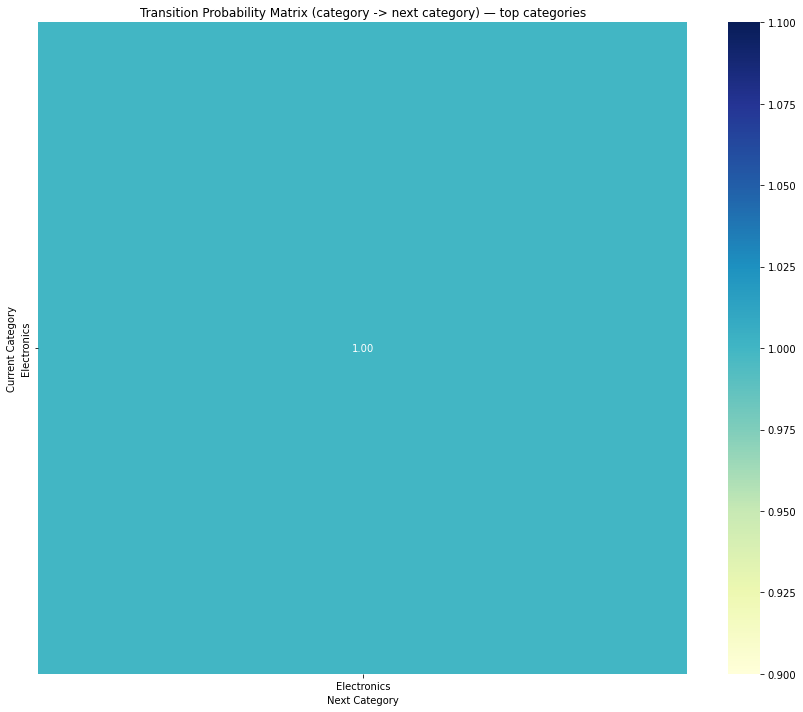

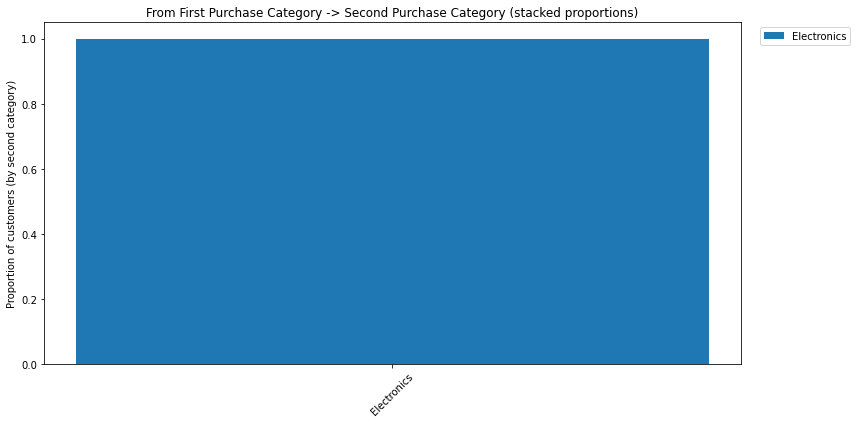

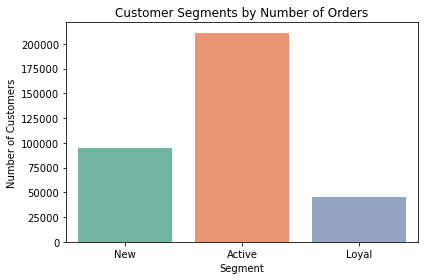

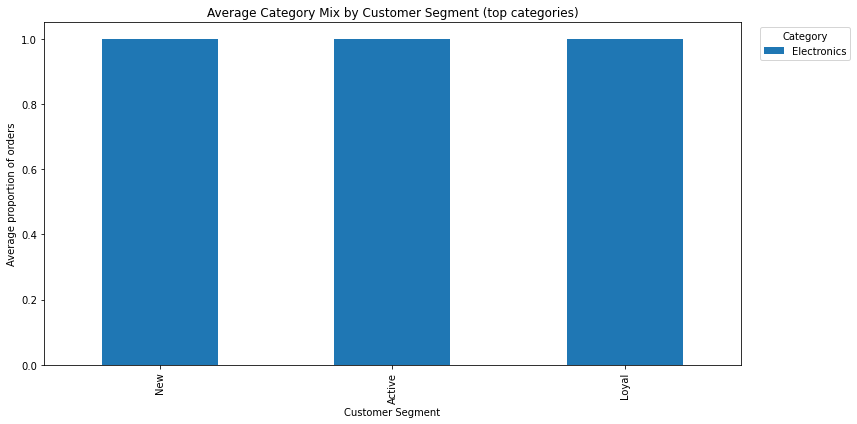

In [54]:
df_j = df.dropna(subset=['customer_id','order_date']).copy()
df_j = df_j.sort_values(['customer_id','order_date'])

# 1) Purchase frequency: number of orders per customer
orders_per_customer = df_j.groupby('customer_id')['order_date'].count().rename('orders').reset_index()
plt.figure(figsize=(10,5))
sns.histplot(orders_per_customer['orders'], bins=50, kde=False)
plt.xlim(1, orders_per_customer['orders'].quantile(0.99)+1)
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# 2) Repeat-purchase intervals (days between consecutive orders), overall distribution
df_j['prev_order_date'] = df_j.groupby('customer_id')['order_date'].shift(1)
df_j['days_since_prev'] = (df_j['order_date'] - df_j['prev_order_date']).dt.days
intervals = df_j['days_since_prev'].dropna()
plt.figure(figsize=(10,5))
sns.histplot(intervals.clip(upper=365), bins=60, kde=True)
plt.title("Distribution of Days Between Consecutive Purchases (clipped at 365 days)")
plt.xlabel("Days between purchases")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) Category transitions: build transition counts between consecutive purchases
df_cat = df_j.dropna(subset=['category']).copy()
df_cat['next_category'] = df_cat.groupby('customer_id')['category'].shift(-1)
transitions = df_cat.dropna(subset=['next_category']).groupby(['category','next_category']).size().reset_index(name='count')
transition_matrix = transitions.pivot(index='category', columns='next_category', values='count').fillna(0)

# Normalize rows to get probabilities
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1).replace(0,1), axis=0)

plt.figure(figsize=(12,10))
# Show top categories only for clarity
top_categories = df_cat['category'].value_counts().head(12).index
transition_prob_subset = transition_prob.loc[top_categories, top_categories].fillna(0)
sns.heatmap(transition_prob_subset, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Transition Probability Matrix (category -> next category) — top categories")
plt.xlabel("Next Category")
plt.ylabel("Current Category")
plt.tight_layout()
plt.show()

# 4) Simple Sankey-like visualization using stacked bars (first vs second category proportions)
# Build first and second category distribution for customers with at least 2 orders
first_second = df_cat.groupby('customer_id').agg(first_cat=('category','first'), second_cat=('category', lambda x: x.iloc[1] if len(x) > 1 else np.nan)).dropna()
fs_counts = first_second.groupby(['first_cat','second_cat']).size().reset_index(name='count')
fs_pivot = fs_counts.pivot(index='first_cat', columns='second_cat', values='count').fillna(0)
# Limit to top 8 first categories for readability
top_first = first_second['first_cat'].value_counts().head(8).index
fs_pivot_sub = fs_pivot.loc[fs_pivot.index.isin(top_first), :]
fs_pivot_sub = fs_pivot_sub[top_categories.intersection(fs_pivot_sub.columns)] if isinstance(top_categories, pd.Index) else fs_pivot_sub

# Plot stacked bars: for each first_cat, stacked by second_cat proportions
fs_props = fs_pivot_sub.div(fs_pivot_sub.sum(axis=1).replace(0,1), axis=0)
plt.figure(figsize=(12,6))
bottom = np.zeros(len(fs_props))
cols = fs_props.columns
for c in cols:
    plt.bar(fs_props.index, fs_props[c], bottom=bottom, label=c)
    bottom += fs_props[c].values
plt.xticks(rotation=45)
plt.ylabel("Proportion of customers (by second category)")
plt.title("From First Purchase Category -> Second Purchase Category (stacked proportions)")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

# 5) Customer evolution: define segments (New, Active, Loyal) by order counts
orders_per_customer = df_j.groupby('customer_id')['order_date'].count().rename('orders').reset_index()
orders_per_customer['segment'] = pd.cut(orders_per_customer['orders'], bins=[0,1,5,9999], labels=['New','Active','Loyal'], right=True)
seg_counts = orders_per_customer['segment'].value_counts().reindex(['New','Active','Loyal']).fillna(0)

plt.figure(figsize=(6,4))
sns.barplot(x=seg_counts.index, y=seg_counts.values, palette='Set2')
plt.title("Customer Segments by Number of Orders")
plt.ylabel("Number of Customers")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

# 6) Category preferences by segment (stacked bar of proportions)
cust_cat = df_j.groupby(['customer_id','category']).size().reset_index(name='count')
cust_total = cust_cat.groupby('customer_id')['count'].sum().reset_index(name='total')
cust_cat = cust_cat.merge(cust_total, on='customer_id')
cust_cat['prop'] = cust_cat['count'] / cust_cat['total']

cust_seg = orders_per_customer[['customer_id','segment']].merge(cust_cat, on='customer_id')
cat_seg = cust_seg.groupby(['segment','category'])['prop'].mean().unstack(fill_value=0)

# Keep top categories for plotting
top_cats_for_seg = df_j['category'].value_counts().head(8).index
cat_seg = cat_seg[top_cats_for_seg.intersection(cat_seg.columns)]

cat_seg.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Average Category Mix by Customer Segment (top categories)")
plt.ylabel("Average proportion of orders")
plt.xlabel("Customer Segment")
plt.legend(title='Category', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

18. Analyze inventory and product lifecycle patterns. Study product launch success, decline phases, and category evolution over the decade with detailed trend analysis.

Inventory columns found: []
Top 5 products by total revenue:
       product_id  total_revenue  peak_revenue  peak_year  launch_year
20    PROD_000021   3.220718e+08   45785681.91       2015         2015
2     PROD_000003   3.024085e+08   43606730.96       2015         2015
1592  PROD_001671   2.760915e+08   34955715.94       2017         2015
1507  PROD_001570   2.520269e+08   40761806.09       2017         2016
215   PROD_000216   2.429514e+08   39334321.60       2018         2017
Lifecycle stage counts:
Growth -> Peak -> Decline    1175
Growing                       619
Declining                     129
Stable/Mature                   2
Name: lifecycle_stage, dtype: int64


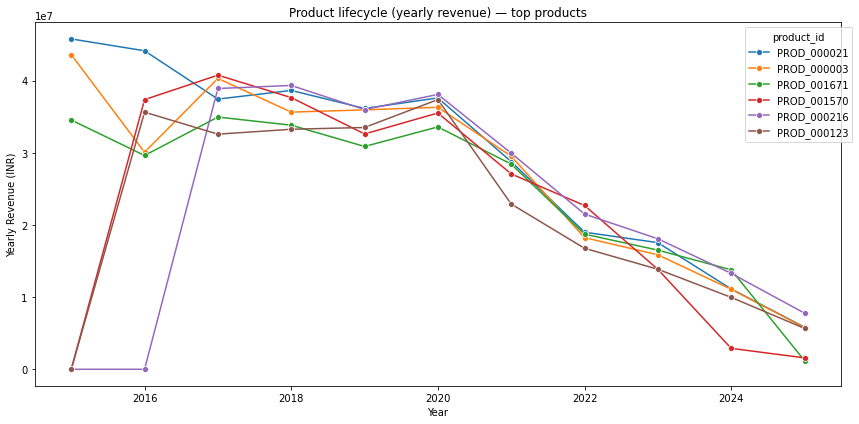

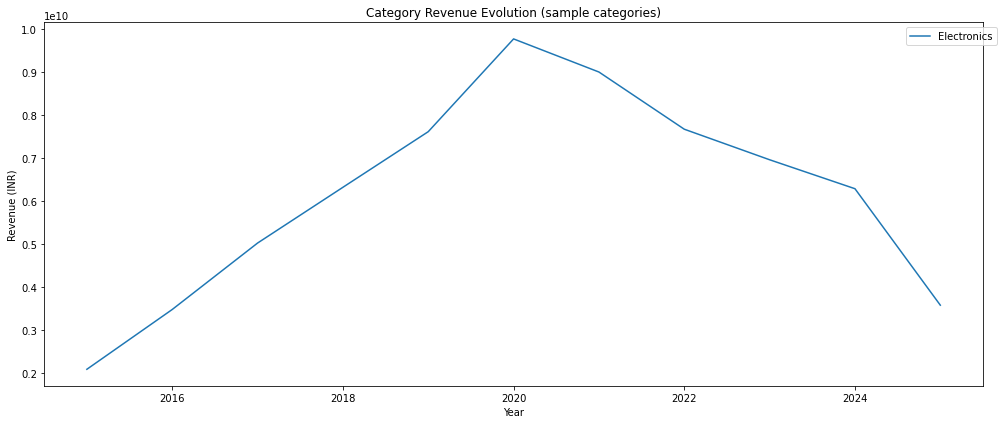

Sample product_summary with avg_monthly_qty:
    product_id  total_revenue  launch_year  peak_year  \
0  PROD_000021   3.220718e+08         2015       2015   
1  PROD_000003   3.024085e+08         2015       2015   
2  PROD_001671   2.760915e+08         2015       2017   
3  PROD_001570   2.520269e+08         2016       2017   
4  PROD_000216   2.429514e+08         2017       2018   

             lifecycle_stage  avg_monthly_qty  
0                  Declining        21.818182  
1                  Declining        21.348485  
2  Growth -> Peak -> Decline        21.238095  
3  Growth -> Peak -> Decline        19.637168  
4  Growth -> Peak -> Decline        19.083333  


In [72]:


# Basic conversions
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['order_year'] = df['order_date'].dt.year
df['final_amount_inr'] = pd.to_numeric(df.get('final_amount_inr'), errors='coerce')
df['quantity'] = pd.to_numeric(df.get('quantity'), errors='coerce')
df['discounted_price_inr'] = pd.to_numeric(df.get('discounted_price_inr'), errors='coerce')

# If inventory columns exist (inventory_count, stock_level, or opening_stock), use them; otherwise we will use sales as proxy
inventory_cols = [c for c in ['inventory_count','stock_level','opening_stock','closing_stock'] if c in df.columns]
print("Inventory columns found:", inventory_cols)

# 1) Product launch year, peak year, and lifetime revenue
prod_first = df.groupby('product_id')['order_date'].min().reset_index().rename(columns={'order_date':'first_sale_date'})
prod_first['launch_year'] = prod_first['first_sale_date'].dt.year

prod_yearly = df.groupby(['product_id','order_year']).agg(yearly_revenue=('final_amount_inr','sum'),
                                                         yearly_qty=('quantity','sum')).reset_index()

# Calculate peak year and total revenue per product
prod_summary = prod_yearly.groupby('product_id').agg(
    total_revenue = ('yearly_revenue','sum'),
    peak_revenue = ('yearly_revenue','max')
).reset_index()

peak_year = prod_yearly.loc[prod_yearly.groupby('product_id')['yearly_revenue'].idxmax(), ['product_id','order_year']].rename(columns={'order_year':'peak_year'})
prod_summary = prod_summary.merge(peak_year, on='product_id', how='left')
prod_summary = prod_summary.merge(prod_first[['product_id','launch_year']], on='product_id', how='left')
prod_summary = prod_summary.sort_values('total_revenue', ascending=False)

print("Top 5 products by total revenue:")
print(prod_summary.head().round(2))

# 2) Identify lifecycle phase for each product using revenue slope around peak
# We'll compute revenue trend before peak and after peak (3-year windows if available)
prod_yearly_sorted = prod_yearly.sort_values(['product_id','order_year'])

# compute revenue change before and after peak for each product
prod_summary['growth_phase_slope'] = np.nan
prod_summary['decline_phase_slope'] = np.nan

for pid in prod_summary['product_id'].head(2000):  # limit iterate for speed if many products
    py = prod_yearly_sorted[prod_yearly_sorted['product_id']==pid].set_index('order_year').reindex(range(df['order_year'].min(), df['order_year'].max()+1), fill_value=0)
    # smooth with rolling 3-year if possible
    rev = py['yearly_revenue'].rolling(window=3, min_periods=1, center=True).mean().values
    years = py.index.values
    # find peak index
    if rev.sum() == 0:
        continue
    peak_idx = np.argmax(rev)
    # slope before peak (linear fit)
    if peak_idx >= 1:
        x_before = np.arange(0, peak_idx)
        y_before = rev[:peak_idx]
        if len(x_before) > 0 and np.ptp(y_before) != 0:
            slope_before = np.polyfit(x_before, y_before, 1)[0]
        else:
            slope_before = 0.0
    else:
        slope_before = np.nan
    # slope after peak
    if peak_idx < len(rev)-1:
        x_after = np.arange(0, len(rev)-peak_idx-1)
        y_after = rev[peak_idx+1:]
        if len(x_after) > 0 and np.ptp(y_after) != 0:
            slope_after = np.polyfit(x_after, y_after, 1)[0]
        else:
            slope_after = 0.0
    else:
        slope_after = np.nan
    prod_summary.loc[prod_summary['product_id']==pid, 'growth_phase_slope'] = slope_before
    prod_summary.loc[prod_summary['product_id']==pid, 'decline_phase_slope'] = slope_after

# 3) Classify lifecycle stage using simple rules
def_stage = []
for i, r in prod_summary.iterrows():
    if pd.isna(r['growth_phase_slope']) and pd.isna(r['decline_phase_slope']):
        def_stage.append('No Data')
    elif (not pd.isna(r['growth_phase_slope']) and r['growth_phase_slope'] > 0.01) and (not pd.isna(r['decline_phase_slope']) and r['decline_phase_slope'] < -0.01):
        def_stage.append('Growth -> Peak -> Decline')
    elif (not pd.isna(r['growth_phase_slope']) and r['growth_phase_slope'] > 0.01):
        def_stage.append('Growing')
    elif (not pd.isna(r['decline_phase_slope']) and r['decline_phase_slope'] < -0.01):
        def_stage.append('Declining')
    else:
        def_stage.append('Stable/Mature')
prod_summary['lifecycle_stage'] = def_stage

print("Lifecycle stage counts:")
print(prod_summary['lifecycle_stage'].value_counts())

# 4) Plot example lifecycle curves for top products
top_n = 6
top_products = prod_summary.head(top_n)['product_id'].tolist()
plt.figure(figsize=(12,6))
for pid in top_products:
    tmp = prod_yearly[prod_yearly['product_id']==pid].set_index('order_year').reindex(sorted(df['order_year'].unique()), fill_value=0)
    sns.lineplot(x=tmp.index, y=tmp['yearly_revenue'], marker='o', label=str(pid))
plt.title("Product lifecycle (yearly revenue) — top products")
plt.xlabel("Year")
plt.ylabel("Yearly Revenue (INR)")
plt.legend(title='product_id', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# 5) Category-level evolution over decade
cat_yearly = df.groupby(['category','order_year'])['final_amount_inr'].sum().reset_index()
plt.figure(figsize=(14,6))
for cat in cat_yearly['category'].unique()[:10]:  # show top 10 categories alphabetically (or adjust)
    tmp = cat_yearly[cat_yearly['category']==cat]
    sns.lineplot(data=tmp, x='order_year', y='final_amount_inr', label=cat)
plt.title("Category Revenue Evolution (sample categories)")
plt.xlabel("Year")
plt.ylabel("Revenue (INR)")
plt.legend(bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# 6) Inventory turnover proxy (if inventory data absent): compute sales velocity = avg monthly qty sold per product
monthly_qty = df.groupby(['product_id', pd.Grouper(key='order_date', freq='M')])['quantity'].sum().reset_index()
monthly_avg = monthly_qty.groupby('product_id')['quantity'].mean().reset_index().rename(columns={'quantity':'avg_monthly_qty'})
prod_summary = prod_summary.merge(monthly_avg, on='product_id', how='left')
print("Sample product_summary with avg_monthly_qty:")
print(prod_summary[['product_id','total_revenue','launch_year','peak_year','lifecycle_stage','avg_monthly_qty']].head())

# 7) If inventory column exists, compute turnover = sales / avg_inventory
if inventory_cols:
    inv_col = inventory_cols[0]
    # assume inventory snapshots exist per product row; compute average inventory per product
    avg_inv = df.groupby('product_id')[inv_col].mean().reset_index().rename(columns={inv_col:'avg_inventory'})
    prod_summary = prod_summary.merge(avg_inv, on='product_id', how='left')
    prod_summary['turnover'] = prod_summary['avg_monthly_qty'] * 12 / (prod_summary['avg_inventory'].replace(0,np.nan))  # annual turnover
    print("Computed turnover (sample):")
    print(prod_summary[['product_id','avg_inventory','turnover']].head())



19 . Build competitive pricing analysis comparing brand positioning, price ranges, and market penetration strategies across different product categories using box plots and competitive matrices.

Top category used for boxplots: Electronics


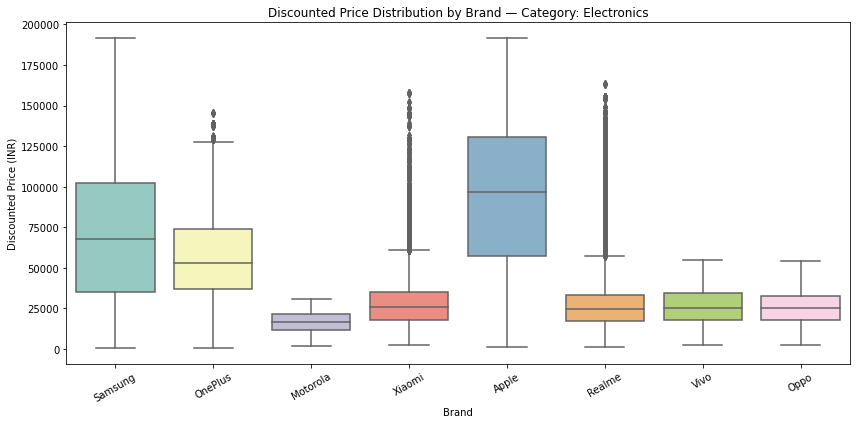

In [65]:
top_category = df['category'].value_counts().idxmax()
print("Top category used for boxplots:", top_category)

cat_df = df[df['category'] == top_category].dropna(subset=['brand', 'discounted_price_inr'])
top_brands_in_cat = cat_df['brand'].value_counts().head(8).index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=cat_df[cat_df['brand'].isin(top_brands_in_cat)],
    x='brand', y='discounted_price_inr', palette='Set3'
)
plt.xticks(rotation=30)
plt.title(f"Discounted Price Distribution by Brand — Category: {top_category}")
plt.xlabel("Brand")
plt.ylabel("Discounted Price (INR)")
plt.tight_layout()
plt.show()


In [67]:
price_stats = df.groupby(['brand', 'category'])['discounted_price_inr'].agg([
    'count',
    'min',
    lambda x: np.percentile(x.dropna(), 25),
    'median',
    lambda x: np.percentile(x.dropna(), 75),
    'max'
]).reset_index()

price_stats.columns = ['brand', 'category', 'count', 'min', 'q1', 'median', 'q3', 'max']
price_stats = price_stats.sort_values(['brand', 'count'], ascending=[True, False])

print("Sample Price Stats (Brand–Category Summary):")
print(price_stats.head(10))



Sample Price Stats (Brand–Category Summary):
            brand     category  count       min          q1     median  \
0            ASUS  Electronics  11707  12301.46  46796.4800  65756.210   
1            Acer  Electronics  13088   8854.87  46494.1575  66268.230   
2       Alienware  Electronics  13031   9435.99  41463.5150  73691.690   
3         Amazfit  Electronics   8536   1872.73  24208.3825  36055.230   
4           Apple  Electronics  87255   1352.88  57534.3700  96927.090   
5  Audio-Technica  Electronics   8629    353.64  12016.8300  18992.050   
6            Boat  Electronics   4781   1009.29   7678.2500  15294.120   
7            Dell  Electronics   8697   9076.05  35061.6900  60722.830   
8      Fire-Boltt  Electronics   7927   1725.98  21071.3500  30930.650   
9          Fitbit  Electronics  10474    770.12  20738.5400  30319.195   

           q3        max  
0  112972.595  189729.93  
1  100266.560  190736.55  
2  115680.620  189550.54  
3   48972.100   67814.45  
4  13

In [68]:
brand_rev = df.groupby('brand')['final_amount_inr'].sum().reset_index().rename(columns={'final_amount_inr': 'revenue'})
brand_qty = df.groupby('brand')['quantity'].sum().reset_index().rename(columns={'quantity': 'volume'})

brand_metrics = brand_rev.merge(brand_qty, on='brand', how='left')
brand_metrics['market_share_revenue_pct'] = brand_metrics['revenue'] / brand_metrics['revenue'].sum() * 100
brand_metrics['market_share_volume_pct'] = brand_metrics['volume'] / brand_metrics['volume'].sum() * 100
brand_metrics = brand_metrics.sort_values('revenue', ascending=False).reset_index(drop=True)

print("Top 10 Brands by Revenue:")
print(brand_metrics.head(10).round(2))




Top 10 Brands by Revenue:
       brand       revenue  volume  market_share_revenue_pct  \
0    Samsung  1.949712e+10  270811                     28.73   
1    OnePlus  1.223383e+10  216432                     18.03   
2      Apple  1.045435e+10  109166                     15.40   
3     Xiaomi  5.409855e+09  194075                      7.97   
4     Realme  2.994832e+09  105135                      4.41   
5       Vivo  2.330791e+09   88033                      3.43   
6       Oppo  2.253189e+09   88254                      3.32   
7     Lenovo  1.905740e+09   27260                      2.81   
8  Alienware  1.294959e+09   16181                      1.91   
9       Acer  1.225253e+09   16405                      1.81   

   market_share_volume_pct  
0                    19.99  
1                    15.98  
2                     8.06  
3                    14.33  
4                     7.76  
5                     6.50  
6                     6.52  
7                     2.01  
8       

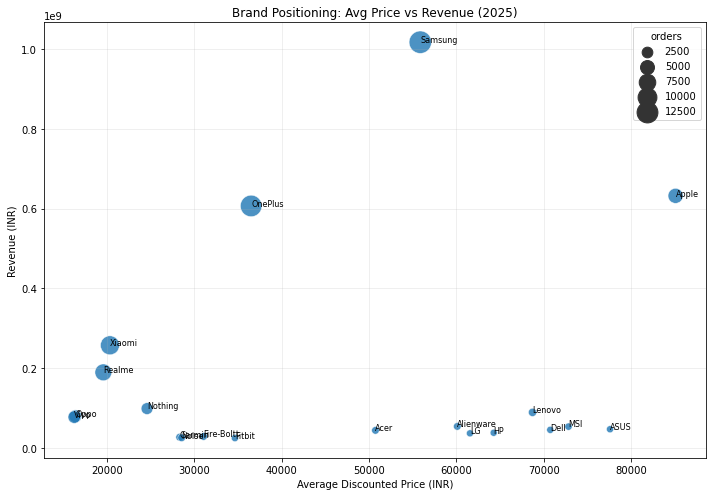

In [69]:
latest_year = df['order_year'].max()
brand_latest = df[df['order_year'] == latest_year].groupby('brand').agg(
    revenue=('final_amount_inr', 'sum'),
    volume=('quantity', 'sum'),
    avg_price=('discounted_price_inr', 'mean'),
    orders=('final_amount_inr', 'count')
).reset_index().dropna(subset=['avg_price'])

top_brands_latest = brand_latest.sort_values('revenue', ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=top_brands_latest, x='avg_price', y='revenue',
    size='orders', sizes=(50, 500), alpha=0.8
)
for i, r in top_brands_latest.iterrows():
    plt.text(r['avg_price'], r['revenue'], r['brand'], fontsize=8)
plt.xlabel("Average Discounted Price (INR)")
plt.ylabel("Revenue (INR)")
plt.title(f"Brand Positioning: Avg Price vs Revenue ({latest_year})")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


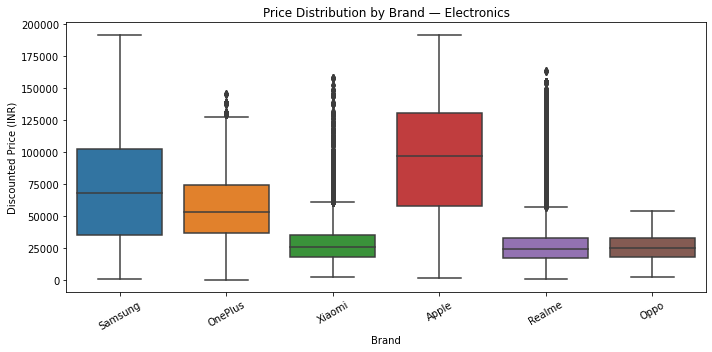

In [70]:
top_categories = df['category'].value_counts().head(6).index

for cat in top_categories:
    tmp = df[df['category'] == cat].dropna(subset=['brand', 'discounted_price_inr'])
    topb = tmp['brand'].value_counts().head(6).index

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=tmp[tmp['brand'].isin(topb)], x='brand', y='discounted_price_inr')
    plt.title(f"Price Distribution by Brand — {cat}")
    plt.xlabel("Brand")
    plt.ylabel("Discounted Price (INR)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


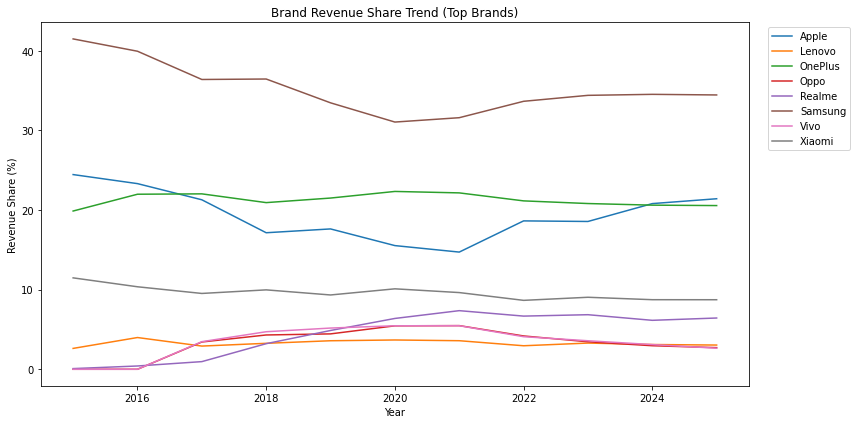

In [71]:
top_brands = brand_metrics['brand'].head(8).tolist()
brand_year = df.groupby(['order_year', 'brand'])['final_amount_inr'].sum().reset_index()
brand_year_top = brand_year[brand_year['brand'].isin(top_brands)].pivot(
    index='order_year', columns='brand', values='final_amount_inr'
).fillna(0)

brand_year_top_pct = brand_year_top.div(brand_year_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
for b in brand_year_top_pct.columns:
    sns.lineplot(data=brand_year_top_pct, x=brand_year_top_pct.index, y=b, label=b)
plt.title("Brand Revenue Share Trend (Top Brands)")
plt.xlabel("Year")
plt.ylabel("Revenue Share (%)")
plt.legend(bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


20 . Create a comprehensive business health dashboard combining key metrics like revenue growth, customer acquisition, retention rates, and operational efficiency using multi-panel visualizations with executive summary insights.


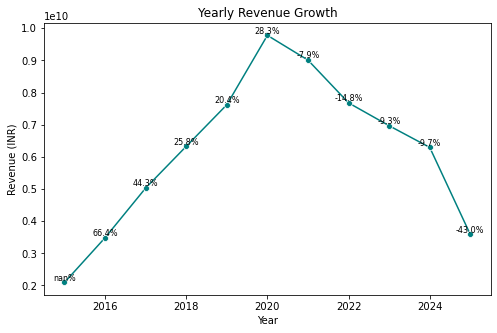

In [59]:
yearly = df.groupby('order_year')['final_amount_inr'].sum().reset_index().sort_values('order_year')
yearly['pct_growth'] = yearly['final_amount_inr'].pct_change() * 100

plt.figure(figsize=(8,5))
sns.lineplot(data=yearly, x='order_year', y='final_amount_inr', marker='o', color='teal')
for i, row in yearly.iterrows():
    plt.text(row['order_year'], row['final_amount_inr'], f"{row['pct_growth']:.1f}%", 
             fontsize=8, ha='center', va='bottom')
plt.title("Yearly Revenue Growth")
plt.ylabel("Revenue (INR)")
plt.xlabel("Year")
plt.show()


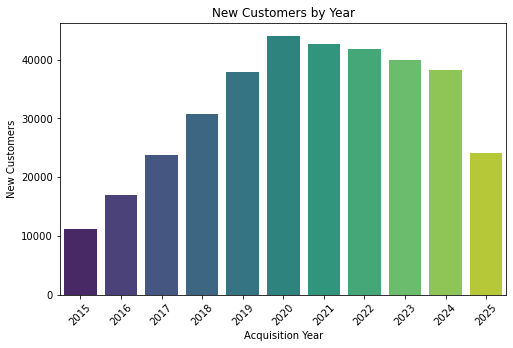

In [60]:
first_order = df.groupby('customer_id')['order_date'].min().reset_index().rename(columns={'order_date':'first_order'})
first_order['acq_year'] = first_order['first_order'].dt.year
acq_by_year = first_order.groupby('acq_year')['customer_id'].nunique().reset_index().rename(columns={'customer_id':'new_customers'})

plt.figure(figsize=(8,5))
sns.barplot(data=acq_by_year, x='acq_year', y='new_customers', palette='viridis')
plt.title("New Customers by Year")
plt.ylabel("New Customers")
plt.xlabel("Acquisition Year")
plt.xticks(rotation=45)
plt.show()


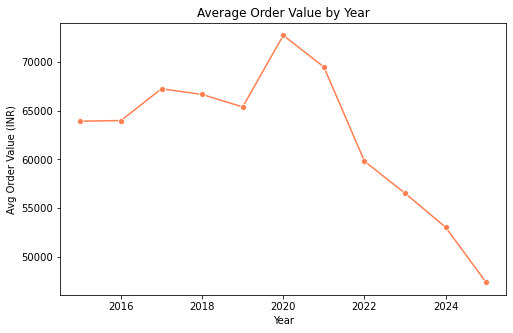

In [62]:
orders = df.groupby('order_year').agg(
    total_revenue=('final_amount_inr','sum'),
    orders=('final_amount_inr','count')
).reset_index()
orders['avg_order_value'] = orders['total_revenue'] / orders['orders']

plt.figure(figsize=(8,5))
sns.lineplot(data=orders, x='order_year', y='avg_order_value', marker='o', color='coral')
plt.title("Average Order Value by Year")
plt.ylabel("Avg Order Value (INR)")
plt.xlabel("Year")
plt.show()


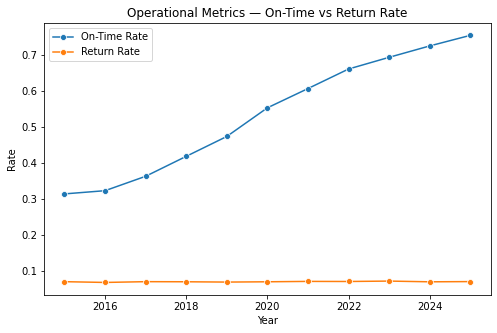

In [63]:
if 'delivery_days' in df.columns:
    df['delivery_days'] = pd.to_numeric(df['delivery_days'], errors='coerce')
    on_time_rate = (df['delivery_days'] <= 3).groupby(df['order_year']).mean().reset_index(name='on_time_rate')
else:
    on_time_rate = pd.DataFrame({'order_year': yearly['order_year'], 'on_time_rate':[np.nan]*len(yearly)})

if 'return_status' in df.columns:
    df['is_returned'] = df['return_status'].astype(str).str.lower().str.contains(r'return|yes|true|y|1', na=False).astype(int)
    return_rate = df.groupby('order_year')['is_returned'].mean().reset_index(name='return_rate')
else:
    return_rate = pd.DataFrame({'order_year': yearly['order_year'], 'return_rate':[np.nan]*len(yearly)})

plt.figure(figsize=(8,5))
sns.lineplot(data=on_time_rate, x='order_year', y='on_time_rate', marker='o', label='On-Time Rate')
sns.lineplot(data=return_rate, x='order_year', y='return_rate', marker='o', label='Return Rate')
plt.title("Operational Metrics — On-Time vs Return Rate")
plt.ylabel("Rate")
plt.xlabel("Year")
plt.legend()
plt.show()


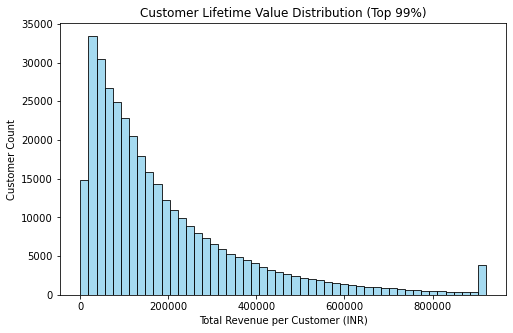

In [64]:
clv = df.groupby('customer_id')['final_amount_inr'].sum().reset_index().rename(columns={'final_amount_inr':'total_revenue'})

plt.figure(figsize=(8,5))
sns.histplot(clv['total_revenue'].clip(upper=clv['total_revenue'].quantile(0.99)), bins=50, color='skyblue')
plt.title("Customer Lifetime Value Distribution (Top 99%)")
plt.xlabel("Total Revenue per Customer (INR)")
plt.ylabel("Customer Count")
plt.show()
